# All Models and Training
## Import necessary libraries

In [21]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [22]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

In [23]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install scikit-plot
    !pip install transformers

In [24]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

os.environ['SSL_CERT_FILE'] = "/Users/ethancui/anaconda3/lib/python3.11/site-packages/certifi/cacert.pem"
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ethancui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ethancui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ethancui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [26]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [27]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [28]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

## Load preprocessed data

In [29]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [30]:
if IN_COLAB:
    preprocessed_dir = 'drive/My Drive/Colab Data/'
    train_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    preprocessed_dir = '../data/preprocessed/'
    train_dir = '../data/train_data/'
    output_dir = '../data/result/'
    lmdict_dir = '../data/LoughranMcDonald/'
    glove_dir = '../data/GloVe/'

In [31]:
# Load previously processed non-text data
# Load data
file = open(train_dir + 'nontext_train_small.pickle', 'rb')
train_df = pickle.load(file)
file.close()

print(train_df.shape)
train_df


(424, 10)


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff
date,,,,,,,,,,
1982-10-05,-1,0,0.456199,38.3,-169.0,2.015140,-0.166667,-0.009960,-15.485275,0.012612
1982-11-16,-1,-1,-0.382299,38.8,-228.0,2.015140,-0.200000,-0.009960,-9.537496,0.012612
1982-12-21,0,-1,-0.382299,39.4,-198.5,2.015140,-0.333333,-0.009960,-3.116275,0.012612
1983-01-14,0,0,-0.382299,39.2,-68.0,2.015140,-0.233333,-0.009960,-0.774432,0.012612
1983-01-21,0,0,-0.382299,39.2,-68.0,2.015140,-0.233333,-0.044058,-0.774432,0.012612
...,...,...,...,...,...,...,...,...,...,...
2022-12-14,1,1,0.801155,50.0,307.0,0.003324,0.033333,0.537643,-15.601750,0.205218
2023-02-01,1,1,0.637398,49.0,264.5,-0.681562,0.000000,0.591459,-17.139080,0.039248
2023-03-22,1,1,0.637398,47.4,360.0,0.156065,0.000000,0.359631,-19.636462,-0.224769


In [32]:
# List of Non-text columns
nontext_columns = train_df.drop(columns=['target']).columns.tolist()
nontext_columns

['prev_decision',
 'GDP_diff_prev',
 'PMI_value',
 'Employ_diff_prev',
 'Rsales_diff_year',
 'Unemp_diff_prev',
 'Inertia_diff',
 'Hsales_diff_year',
 'Balanced_diff']

In [33]:
# Load text data
file = open(preprocessed_dir + 'text_no_split.pickle', 'rb') # Original text
text_no_split = pickle.load(file)
file.close()

file = open(preprocessed_dir + 'text_split_200.pickle', 'rb') # Split at 200 words
text_split_200 = pickle.load(file)
file.close()


file = open(preprocessed_dir + 'text_keyword.pickle', 'rb') # Paragraphs filtered for those having keywords
text_keyword = pickle.load(file)
file.close()

## Check the statistics of texts

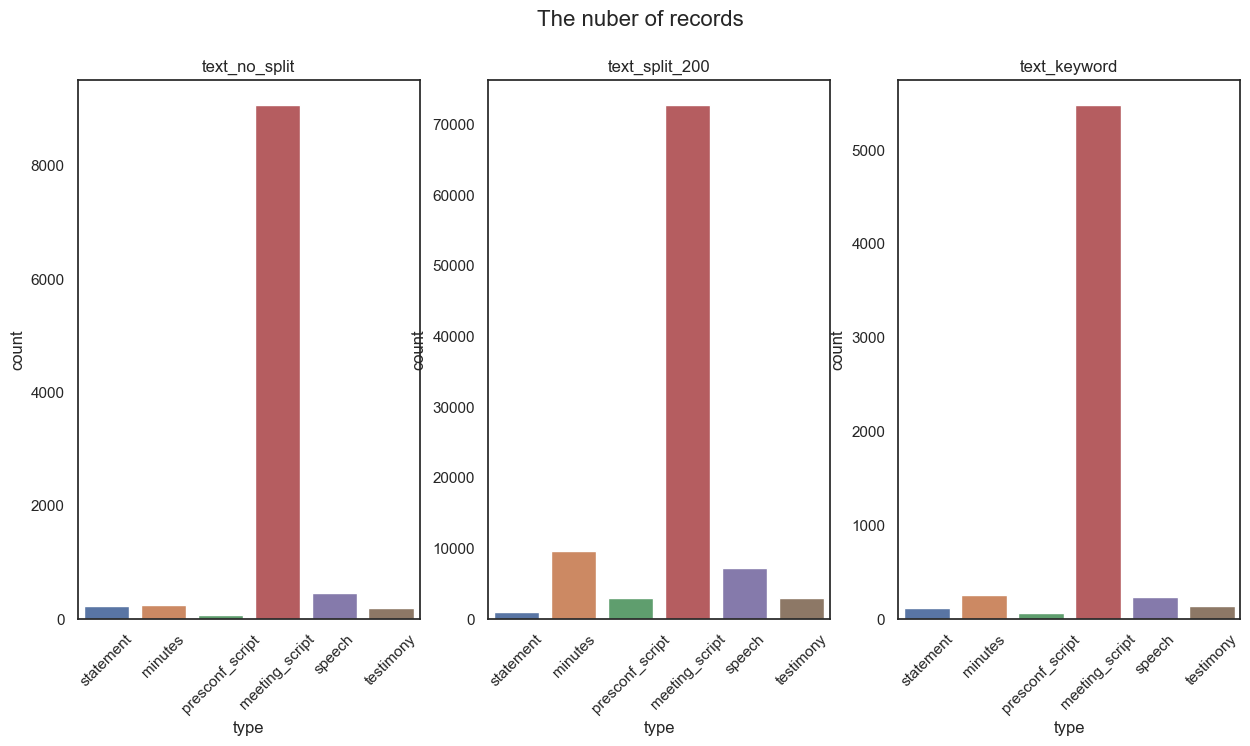

In [34]:
# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()


In [35]:
text_no_split.loc[text_no_split['type'] == 'meeting_script'].head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
541,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,3596,-1,9.5,1982-11-16,-1,9.0,I thought it had been level for a lon...
542,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER. It was a group of ABA,686,-1,9.5,1982-11-16,-1,9.0,"bankers, but that'sincidental. It is goin..."
543,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,6153,-1,9.5,1982-11-16,-1,9.0,"Well, I want to come back to some of t..."
544,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. AXILROD,544,-1,9.5,1982-11-16,-1,9.0,If there were not a specification for M...
545,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BALLES,545,-1,9.5,1982-11-16,-1,9.0,"Well, coming at this confidence factor ..."


There are many meeting scripts but we do not use them this time as they cannot be used for prediction of the rate decision because meeting scripts are published four years after the meeting.

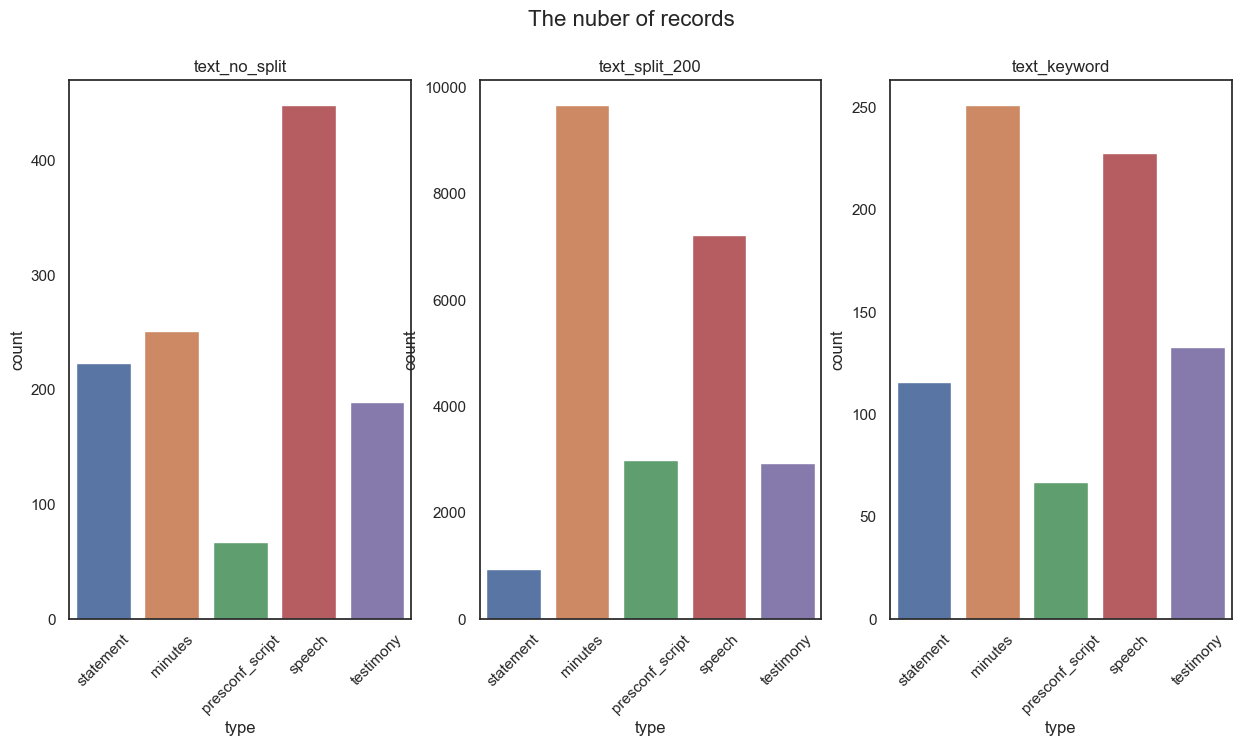

In [36]:
# Drop meeting script data
text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()

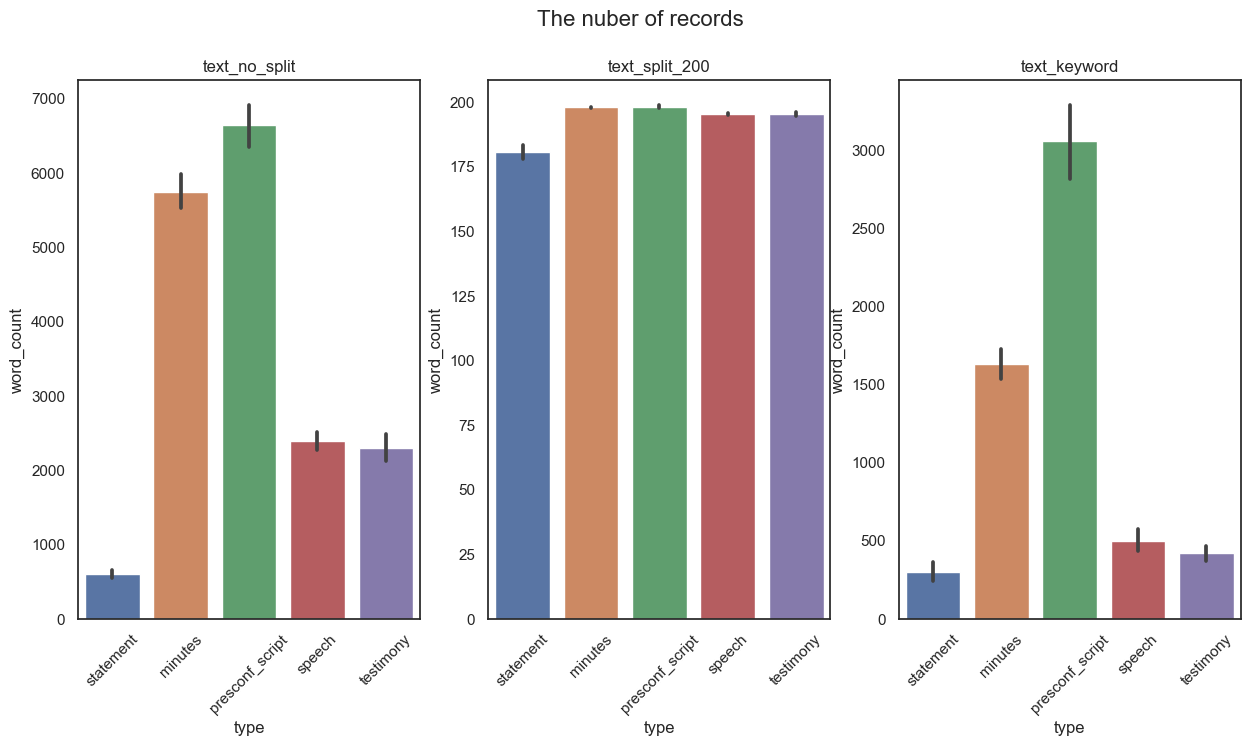

In [37]:
# Check the number of words per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.barplot(data=text_no_split, x='type', y='word_count', ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.barplot(x='type', y='word_count', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.barplot(x='type', y='word_count', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()

### Select text dataframe

In [38]:
# Select one from the above different pre-processed data
text_df = text_no_split
text_df.reset_index(drop=True, inplace=True)
print(text_df.shape)

# Assuming you have already defined text_df and reset the index as mentioned

text_df

(1178, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."
...,...,...,...,...,...,...,...,...,...,...,...
1173,testimony,2022-01-11,Nomination hearing,Jerome Powell,654,NaN,None,2022-01-26,0,0.00,"Chairman Brown, Ranking Member Toomey, and oth..."
1174,testimony,2022-03-02,Semiannual Monetary Policy Report to the Congress,Jerome Powell,801,NaN,None,2022-03-16,1,0.25,"At the Federal Reserve, we are strongly commit..."
1175,testimony,2022-06-22,Semiannual Monetary Policy Report to the Congress,Jerome Powell,864,NaN,None,2022-07-27,1,2.25,I will begin with one overarching message. At ...
1176,testimony,2023-03-07,Semiannual Monetary Policy Report to the Congress,Jerome Powell,931,NaN,None,2023-03-22,1,4.75,My colleagues and I are acutely aware that hig...


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/1028783177.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=False, color='r')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/1028783177.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwas

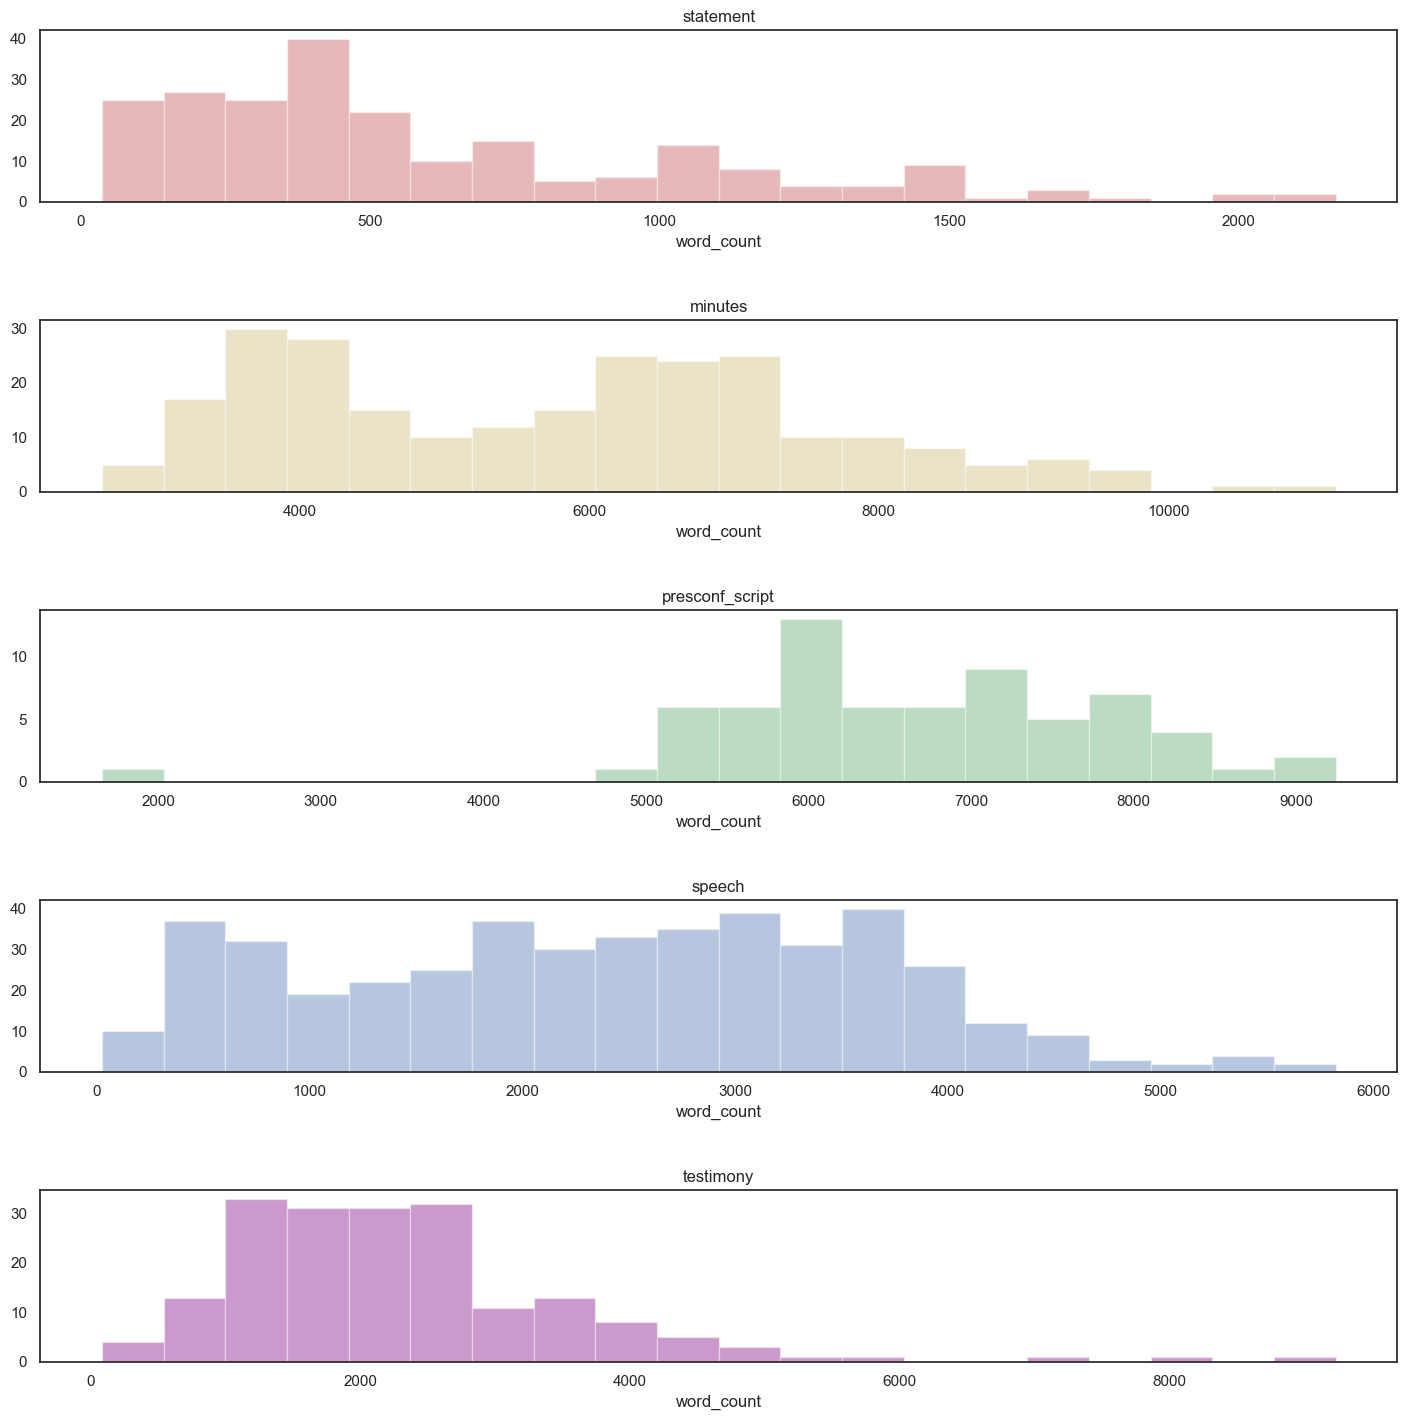

In [39]:
# Check distribution

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))
doc_type = 'statement'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=False, color='r')
ax1.set_title(doc_type)
doc_type = 'minutes'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=False, color='y')
ax2.set_title(doc_type)
doc_type = 'presconf_script'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=False, color='g')
ax3.set_title(doc_type)
doc_type = 'speech'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=False, color='b')
ax4.set_title(doc_type)
doc_type = 'testimony'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=False, color='purple')
ax5.set_title(doc_type)

fig.tight_layout(pad=3.0)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


TypeError: boolean value of NA is ambiguous

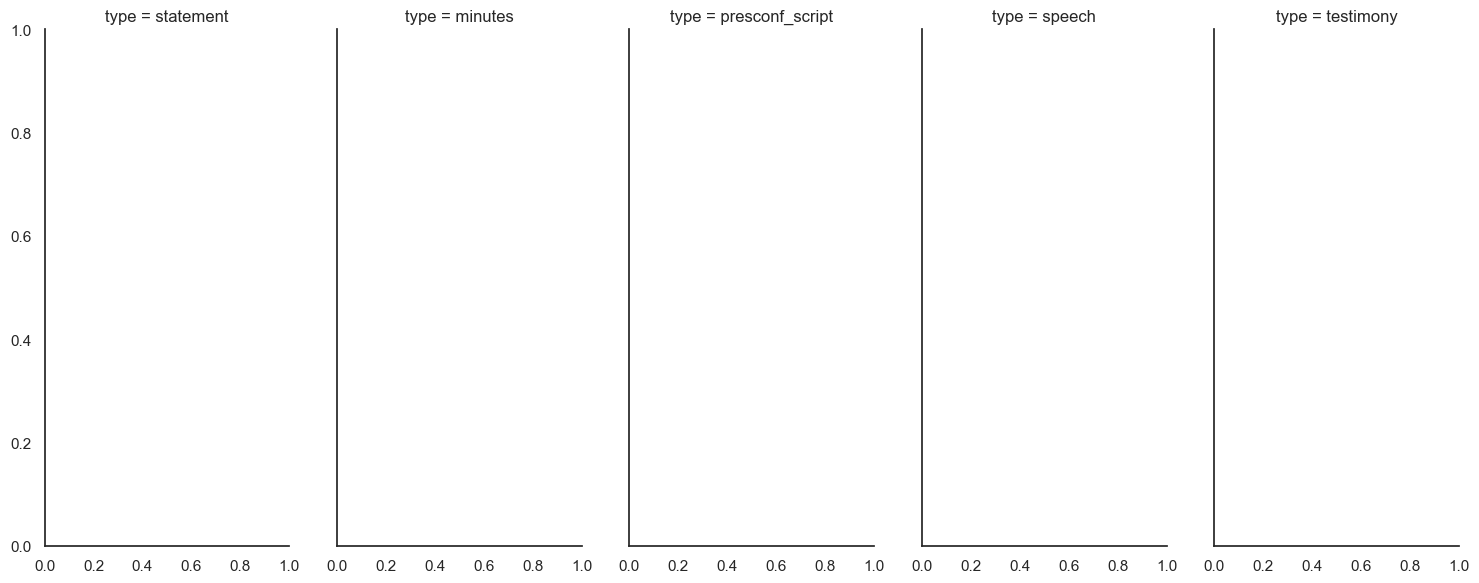

In [40]:
# Check balance of Rate Decision

g = sns.FacetGrid(text_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()


The label is highly biased to 0(Hold). Need to consider how to mitigate the biased data.

## Merge text to the train dataframe

In [41]:
from collections import defaultdict 

doc_types = text_df['type'].unique()

merged_dict = defaultdict(list)

for i, row in train_df.iterrows():
    text_rows = text_df.loc[text_df['next_meeting'] == i]
    merged_text_all = ""
    for doc_type in doc_types:
        merged_text = ""
        for text in text_rows.loc[text_rows['type'] == doc_type]['text']:
            merged_text += " " + text
        merged_dict[doc_type].append(merged_text)
        merged_text_all += merged_text
    merged_dict['text'].append(merged_text_all)
    

In [42]:
for key in merged_dict.keys():
    train_df[key] = merged_dict[key]

train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text
date,,,,,,,,,,,,,,,,
1982-10-05,-1,0,0.456199,38.3,-169.0,2.015140,-0.166667,-0.009960,-15.485275,0.012612,,,,,,
1982-11-16,-1,-1,-0.382299,38.8,-228.0,2.015140,-0.200000,-0.009960,-9.537496,0.012612,,,,,,
1982-12-21,0,-1,-0.382299,39.4,-198.5,2.015140,-0.333333,-0.009960,-3.116275,0.012612,,,,,,
1983-01-14,0,0,-0.382299,39.2,-68.0,2.015140,-0.233333,-0.009960,-0.774432,0.012612,,,,,,
1983-01-21,0,0,-0.382299,39.2,-68.0,2.015140,-0.233333,-0.044058,-0.774432,0.012612,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,1,1,0.801155,50.0,307.0,0.003324,0.033333,0.537643,-15.601750,0.205218,The Committee seeks to achieve maximum employ...,Committee Ethics Discussion The Chair began w...,Good afternoon. My colleagues and I are str...,Today I will offer a progress report on the F...,,The Committee seeks to achieve maximum employ...
2023-02-01,1,1,0.637398,49.0,264.5,-0.681562,0.000000,0.591459,-17.139080,0.039248,The Committee seeks to achieve maximum employ...,Developments in Financial Markets and Open Ma...,Good afternoon. Before I go into the detail...,"I will address three main points. First, the ...",,The Committee seeks to achieve maximum employ...
2023-03-22,1,1,0.637398,47.4,360.0,0.156065,0.000000,0.359631,-19.636462,-0.224769,The Committee seeks to achieve maximum employ...,"By unanimous vote, the Committee selected Pat...","Good afternoon, and welcome. My colleagues ...",,My colleagues and I are acutely aware that hi...,The Committee seeks to achieve maximum employ...


In [43]:
# Check if most of docs are merged

count_text, count_train = 0, 0

for doc_type in doc_types:
    count = 0
    for text in text_df.loc[text_df['type']==doc_type]['text']:
        count += len(text.split())
    print("{} words in original text for {}".format(count, doc_type))
    count_text += count
    
    count = 0
    for text in train_df[doc_type]:
        count += len(text.split())
    print("{} words in merged text for {}".format(count, doc_type))
    count_train += count

print("Total: {} words in original text".format(count_text))
print("Total: {} words in merged text".format(count_train))
print("Total: {} words in text column of merged text".format(train_df['text'].apply(lambda x: len(x.split())).sum()))

134005 words in original text for statement
133778 words in merged text for statement
1434427 words in original text for minutes
1428754 words in merged text for minutes
426665 words in original text for presconf_script
420042 words in merged text for presconf_script
1063496 words in original text for speech
1061928 words in merged text for speech
431941 words in original text for testimony
431077 words in merged text for testimony
Total: 3490534 words in original text
Total: 3475579 words in merged text
Total: 3475579 words in text column of merged text


Looks okay, but there are may rows without text as texts are only available from certain year.
It's not easy to fill those null values - for now drop those though the number of training data gets small...

In [44]:
print("Before dropping: ", train_df.shape)
train_df = train_df.loc[train_df['text'] != ""]
print("After dropping: ", train_df.shape)

Before dropping:  (424, 16)
After dropping:  (271, 16)


## Explore the text

In [45]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [46]:
corpus = create_corpus(text_df)

In [47]:
x, y = get_frequent_stop_words(corpus)

In [48]:
print(x)
print(y)

('the', 'of', 'in', 'to', 'and', 'that', 'a', 'for', 'on', 'as')
(236441, 127423, 106280, 104596, 102131, 54093, 53868, 36261, 26452, 25281)


In [49]:
x, y = get_frequent_nonstop_words(corpus)

In [50]:
print(x)
print(y)

('economic', 'inflation', 'financial', 'federal', 'would', 'market', 'rate', 'policy', 'growth', 'committee')
(15638, 15493, 14605, 14408, 12910, 12751, 11799, 11547, 9762, 8857)


<Axes: >

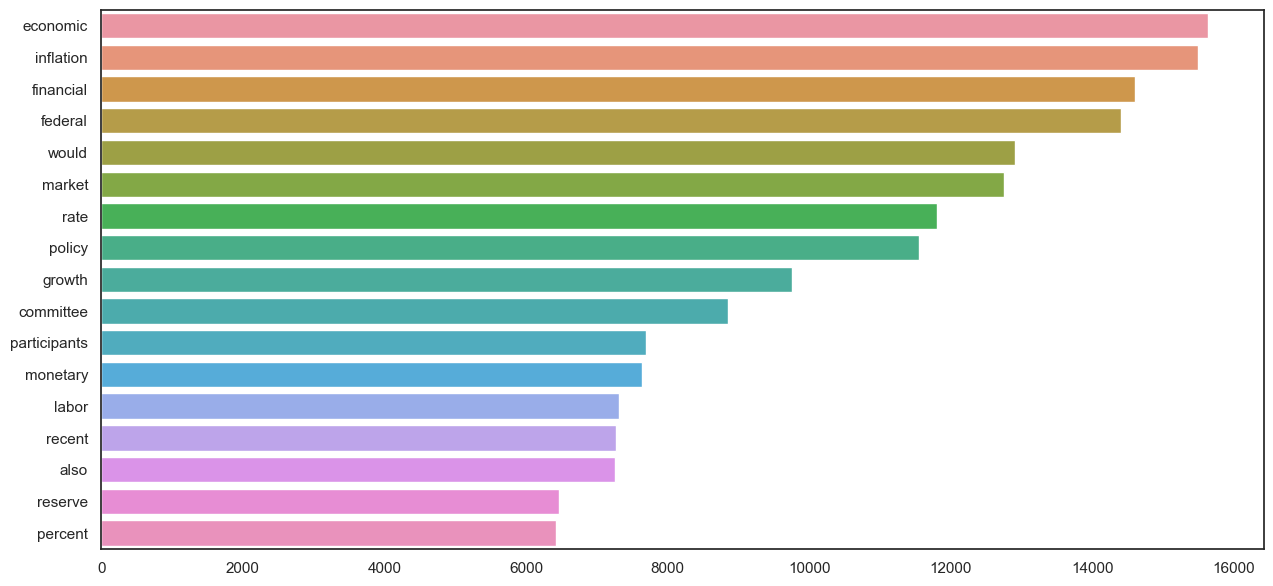

In [51]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

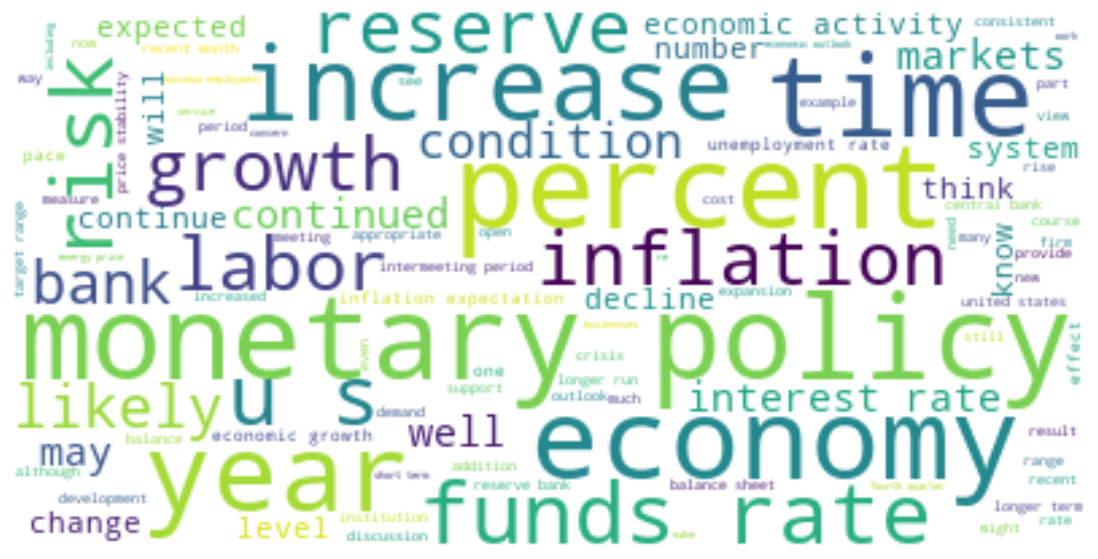

In [52]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


# Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires license to use for commercial application. Please check their website.

In [53]:
# Load sentiment data
sentiment_df = pd.read_csv(lmdict_dir + 'Loughran-McDonald_MasterDictionary_1993-2021.csv')

print(sentiment_df.shape)
sentiment_df

(86531, 16)


,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,ZYGOTE,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,ZYGOTES,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [54]:
# select only when these values zero non zero
filtered_df = sentiment_df[~(sentiment_df[['Negative', 'Positive', 'Uncertainty', 'Litigious', 'Strong_Modal', 'Weak_Modal', 'Constraining']] == 0).all(axis=1)]


filtered_df = filtered_df[['Word','Negative', 'Positive', 'Uncertainty', 'Litigious', 'Strong_Modal', 'Weak_Modal', 'Constraining']]


filtered_df['sentiment'] = filtered_df[['Negative', 'Positive', 'Uncertainty', 'Litigious', 'Strong_Modal', 'Weak_Modal', 'Constraining']].idxmax(axis=1)


# Drop the original columns (Negative, Positive, Uncertainty, Litigious, Strong_Modal, Weak_Modal, Constraining)
filtered_df.drop(columns=['Negative', 'Positive', 'Uncertainty', 'Litigious', 'Strong_Modal', 'Weak_Modal', 'Constraining','Weak_Modal'], inplace=True)
sentiment_df = filtered_df

# change column to lower case and swap order
sentiment_df.rename(columns=lambda x: x.lower(), inplace=True)
sentiment_df = sentiment_df[['sentiment','word']]
sentiment_df.reset_index(drop = True)

,sentiment,word
0,Negative,ABANDON
1,Negative,ABANDONED
2,Negative,ABANDONING
3,Negative,ABANDONMENT
4,Negative,ABANDONMENTS
...,...,...
3871,Negative,WRONGDOING
3872,Negative,WRONGDOINGS
3873,Negative,WRONGFUL
3874,Negative,WRONGFULLY


In [55]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,159
Litigious,749
Negative,2345
Positive,356
Strong_Modal,15
Uncertainty,252


In [56]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [57]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [58]:
# Analyze tone for original text dataframe
print(text_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm(text_df['text'], total=text_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
text_df = pd.concat([text_df, tone_lmdict_df.reindex(text_df.index)], axis=1)
text_df


(1178, 11)


  0%|          | 0/1178 [00:00<?, ?it/s]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0.000000,99,1,1,[enhance],[misunderstanding]
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,0.000000,40,0,0,[],[]
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,0.000000,37,0,0,[],[]
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",0.000000,57,0,0,[],[]
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",0.000000,51,0,0,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,testimony,2022-01-11,Nomination hearing,Jerome Powell,654,NaN,None,2022-01-26,0,0.00,"Chairman Brown, Ranking Member Toomey, and oth...",0.917431,654,21,15,"[opportunity, progress, enjoying, attractive, ...","[crisis, unemployment, imbalances, threatened,..."
1174,testimony,2022-03-02,Semiannual Monetary Policy Report to the Congress,Jerome Powell,801,NaN,None,2022-03-16,1,0.25,"At the Federal Reserve, we are strongly commit...",-0.124844,801,17,18,"[achieving, stability, progress, gains, improv...","[slowing, declined, sharply, slowdown, unemplo..."
1175,testimony,2022-06-22,Semiannual Monetary Policy Report to the Congress,Jerome Powell,864,NaN,None,2022-07-27,1,2.25,I will begin with one overarching message. At ...,0.000000,864,14,14,"[resolve, stability, strong, strong, strong, s...","[hardship, benefit, volatile, exacerbate, disr..."
1176,testimony,2023-03-07,Semiannual Monetary Policy Report to the Congress,Jerome Powell,931,NaN,None,2023-03-22,1,4.75,My colleagues and I are acutely aware that hig...,-1.611171,931,14,29,"[stable, stability, gains, strong, good, despi...","[hardship, tightening, stability (with negatio..."


In [59]:
# Analyze tone for training dataframe
tone_lmdict_list = []
for doc_type in doc_types:
    tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x)[0] for x in tqdm(train_df[doc_type], 
                                                                                      total=train_df.shape[0], 
                                                                                      desc=doc_type)]
    tone_lmdict_list.append(tone_lmdict)
    
train_df['tone'] = np.mean(tone_lmdict_list, axis=0)
train_df

statement:   0%|          | 0/271 [00:00<?, ?it/s]

minutes:   0%|          | 0/271 [00:00<?, ?it/s]

presconf_script:   0%|          | 0/271 [00:00<?, ?it/s]

speech:   0%|          | 0/271 [00:00<?, ?it/s]

testimony:   0%|          | 0/271 [00:00<?, ?it/s]

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/1409108802.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tone'] = np.mean(tone_lmdict_list, axis=0)


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text,tone
date,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.042880,54.2,257.5,2.015140,0.000000,-0.015006,14.901418,0.030023,,The Secretary reported that advices of the el...,,,,The Secretary reported that advices of the el...,-0.160909
1993-05-18,0,0,0.166979,53.5,125.5,3.092456,0.066667,0.003106,13.455236,0.088803,,"At the start of the meeting, the subcommittee...",,,,"At the start of the meeting, the subcommittee...",-0.178945
1993-07-07,0,0,0.166979,51.2,228.0,4.263357,0.000000,0.053298,13.446869,-0.036990,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.276393
1993-08-17,0,0,0.582113,49.6,245.0,4.611673,0.066667,0.004418,11.927296,0.011994,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.142653
1993-09-21,0,0,0.582113,50.2,229.0,4.894733,0.100000,-0.004671,10.302509,-0.025253,,Secretary's Note: Advice had been received of...,,,,Secretary's Note: Advice had been received of...,-0.218009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,1,1,0.801155,50.0,307.0,0.003324,0.033333,0.537643,-15.601750,0.205218,The Committee seeks to achieve maximum employ...,Committee Ethics Discussion The Chair began w...,Good afternoon. My colleagues and I are str...,Today I will offer a progress report on the F...,,The Committee seeks to achieve maximum employ...,-0.885747
2023-02-01,1,1,0.637398,49.0,264.5,-0.681562,0.000000,0.591459,-17.139080,0.039248,The Committee seeks to achieve maximum employ...,Developments in Financial Markets and Open Ma...,Good afternoon. Before I go into the detail...,"I will address three main points. First, the ...",,The Committee seeks to achieve maximum employ...,-0.259772
2023-03-22,1,1,0.637398,47.4,360.0,0.156065,0.000000,0.359631,-19.636462,-0.224769,The Committee seeks to achieve maximum employ...,"By unanimous vote, the Committee selected Pat...","Good afternoon, and welcome. My colleagues ...",,My colleagues and I are acutely aware that hi...,The Committee seeks to achieve maximum employ...,-0.725859


In [60]:
text_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0.000000,99,1,1,[enhance],[misunderstanding]
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,0.000000,40,0,0,[],[]
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,0.000000,37,0,0,[],[]
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",0.000000,57,0,0,[],[]
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",0.000000,51,0,0,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,testimony,2022-01-11,Nomination hearing,Jerome Powell,654,NaN,None,2022-01-26,0,0.00,"Chairman Brown, Ranking Member Toomey, and oth...",0.917431,654,21,15,"[opportunity, progress, enjoying, attractive, ...","[crisis, unemployment, imbalances, threatened,..."
1174,testimony,2022-03-02,Semiannual Monetary Policy Report to the Congress,Jerome Powell,801,NaN,None,2022-03-16,1,0.25,"At the Federal Reserve, we are strongly commit...",-0.124844,801,17,18,"[achieving, stability, progress, gains, improv...","[slowing, declined, sharply, slowdown, unemplo..."
1175,testimony,2022-06-22,Semiannual Monetary Policy Report to the Congress,Jerome Powell,864,NaN,None,2022-07-27,1,2.25,I will begin with one overarching message. At ...,0.000000,864,14,14,"[resolve, stability, strong, strong, strong, s...","[hardship, benefit, volatile, exacerbate, disr..."
1176,testimony,2023-03-07,Semiannual Monetary Policy Report to the Congress,Jerome Powell,931,NaN,None,2023-03-22,1,4.75,My colleagues and I are acutely aware that hig...,-1.611171,931,14,29,"[stable, stability, gains, strong, good, despi...","[hardship, tightening, stability (with negatio..."


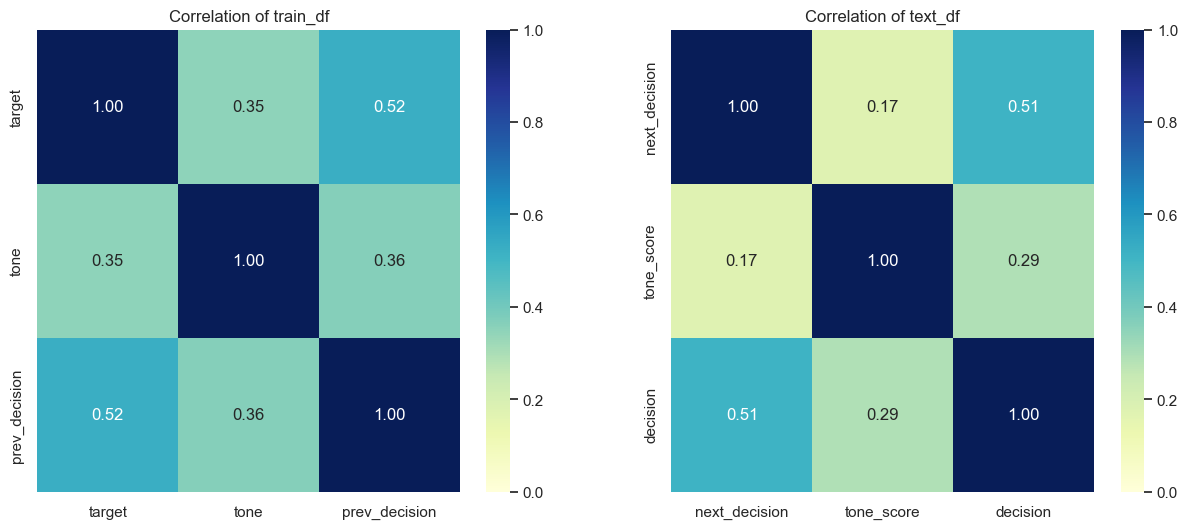

In [61]:
# Show corelations to next_decision
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

corr_columns = ['target', 'tone', 'prev_decision']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax1, vmin=0, vmax=1)
ax1.set_title("Correlation of train_df")

corr_columns = ['next_decision', 'tone_score', 'decision']
tmp_df = pd.DataFrame()
for column in corr_columns:
    tmp_df[column] = pd.to_numeric(text_df[column], errors='coerce')
sns.heatmap(tmp_df.astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax2, vmin=0, vmax=1)
ax2.set_title("Correlation of text_df")

plt.show()

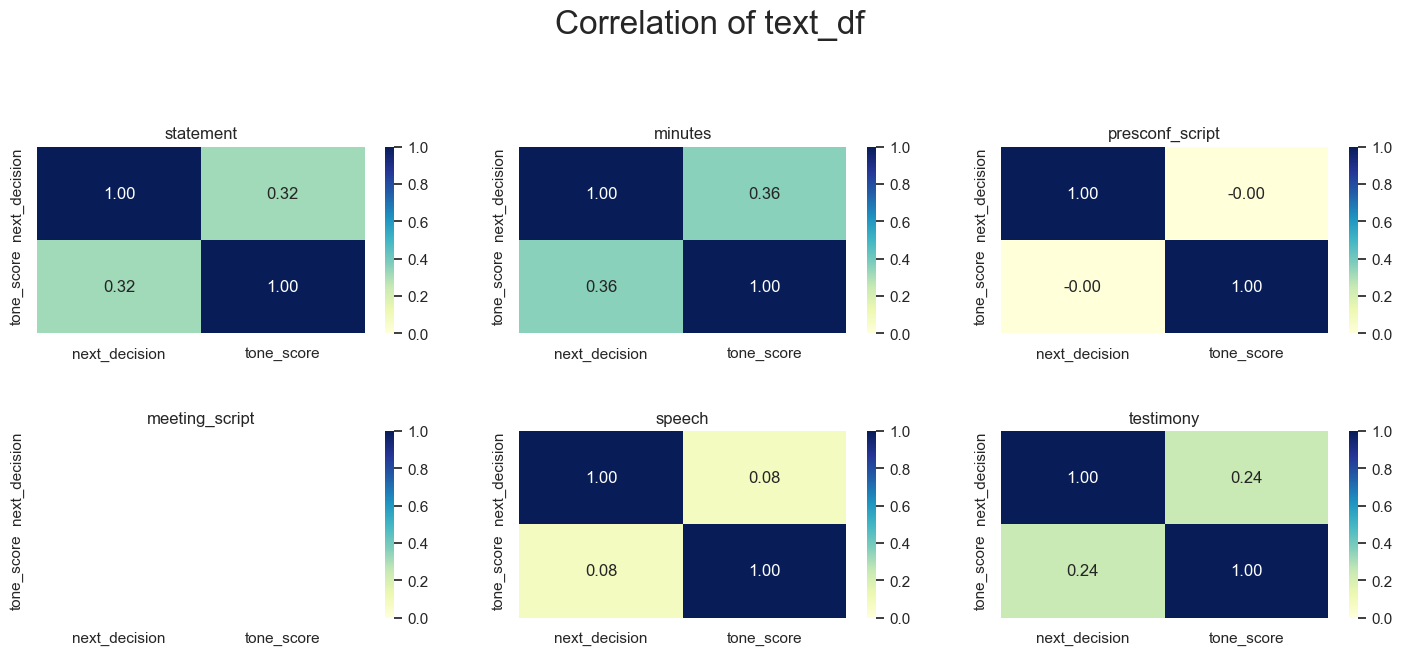

In [62]:
# Per document type
corr_columns = ['next_decision', 'tone_score', 'type']
tmp_df = pd.DataFrame()
for column in corr_columns:
    tmp_df[column] = pd.to_numeric(text_df[column], errors='coerce')
tmp_df['type'] = text_df['type']
doc_types = ['statement', 'minutes', 'presconf_script', 'meeting_script', 'speech', 'testimony']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for i, doc_type in enumerate(doc_types):
    sns.heatmap(tmp_df.loc[tmp_df['type'] == doc_type].drop(columns=['type']).astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(doc_type)

fig.suptitle('Correlation of text_df', fontsize=24)
fig.tight_layout(pad=3.0)
plt.show()

# Tokenize and vectorize

In [63]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='text'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it loser case
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        # Lemmatize words 
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized


## Tokenize text_df

In [64]:
tokenized_org = tokenize_df(text_df)
print('len(tokenized_org): ', len(tokenized_org))
print(tokenized_org[0])

  0%|          | 0/1178 [00:00<?, ?it/s]

len(tokenized_org):  1178
['chairman', 'alan', 'greenspan', 'announce', 'today', 'federal', 'open', 'market', 'committee', 'decide', 'increase', 'slightly', 'degree', 'pressure', 'reserve', 'position', 'the', 'action', 'expect', 'associate', 'small', 'increase', 'money', 'market', 'interest', 'rate', 'the', 'decision', 'take', 'move', 'toward', 'le', 'accommodative', 'stance', 'monetary', 'policy', 'order', 'sustain', 'enhance', 'economic', 'expansion', 'chairman', 'greenspan', 'decide', 'announce', 'action', 'immediately', 'avoid', 'misunderstand', 'committee', 'purpose', 'give', 'fact', 'first', 'firm', 'reserve', 'market', 'condition', 'committee', 'since', 'early']


In [65]:
# Concat the list to create docs
lemma_docs_org = [" ".join(words) for words in tokenized_org]
print('len(lemma_docs_org): ', len(lemma_docs_org))
print(lemma_docs_org[0])

len(lemma_docs_org):  1178
chairman alan greenspan announce today federal open market committee decide increase slightly degree pressure reserve position the action expect associate small increase money market interest rate the decision take move toward le accommodative stance monetary policy order sustain enhance economic expansion chairman greenspan decide announce action immediately avoid misunderstand committee purpose give fact first firm reserve market condition committee since early


In [66]:
# Create a list of all the words in the dataframe
all_words_org = [word for text in tokenized_org for word in text]
print('len(all_words_org): ', len(all_words_org))
print(all_words_org[0])

# Counter object of all the words
counts_org = Counter(all_words_org)
print('len(counts_org): ', len(counts_org))

# Create a Bag of Word, sorted by the count of words
bow_org = sorted(counts_org, key=counts_org.get, reverse=True)
print('bow_org[:20]', bow_org[:20])

# Indexing vocabrary, starting from 1.
vocab_org = {word: ii for ii, word in enumerate(counts_org, 1)}
id2vocab_org = {v: k for k, v in vocab_org.items()}

print("vocab_org['chairman']: ", vocab_org['chairman'])
print("vocab_org['market']: ", vocab_org['market'])

len(all_words_org):  2048556
chairman
len(counts_org):  20799
bow_org[:20] ['market', 'rate', 'the', 'inflation', 'economic', 'policy', 'price', 'financial', 'federal', 'committee', 'bank', 'would', 'increase', 'growth', 'year', 'in', 'continue', 'i', 'economy', 'percent']
vocab_org['chairman']:  1
vocab_org['market']:  8


In [67]:
# Create token id list
token_ids_org = [[vocab_org[word] for word in text_words] for text_words in tokenized_org]
print(len(token_ids_org))

1178


In [68]:
# Add to the dataframe
text_df['tokenized'] = tokenized_org
text_df['token_ids'] = token_ids_org

In [69]:
# # Filter by frequency of words
# # This time, switch it off as the frequency is already considered while creating the vocabrary

# freq = {}
# num_words = len(all_words)
# print('len(all_words): ', len(all_words))

# for key in counts:
#     freq[key] = counts[key]/num_words

# print('len(freq): ', len(freq))
# print(freq['rate'])

# low_cutoff = 0.000001
# high_cutoff = 20

# K_most_common, K_most_common_values = zip(*counts.most_common()[:high_cutoff])

# filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
# print(K_most_common)
# print('len(filtered_words): ', len(filtered_words))

## Tokenize train_df

In [70]:
tokenized = tokenize_df(train_df)
print('len(tokenized): ', len(tokenized))
print(tokenized[0])

# Concat the list to create docs
lemma_docs = [" ".join(words) for words in tokenized]
print('len(lemma_docs): ', len(lemma_docs))
print(lemma_docs[0])

# Create a list of all the words in the dataframe
all_words = [word for text in tokenized for word in text]
print('len(all_words): ', len(all_words))
print(all_words[0])

# Counter object of all the words
counts = Counter(all_words)
print('len(counts): ', len(counts))

# Create a Bag of Word, sorted by the count of words
bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

# Indexing vocabrary, starting from 1.
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

# Create token id list
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]
print(len(token_ids))

# Add to the dataframe
train_df['tokenized'] = tokenized
train_df['token_ids'] = token_ids
train_df['tokenized_text'] = train_df['tokenized'].apply(lambda x: " ".join(x))

  0%|          | 0/271 [00:00<?, ?it/s]

len(tokenized):  271
['the', 'secretary', 'report', 'advice', 'election', 'reserve', 'bank', 'member', 'alternate', 'member', 'federal', 'open', 'market', 'committee', 'period', 'commence', 'january', 'end', 'december', 'receive', 'individual', 'execute', 'oath', 'office', 'the', 'elect', 'member', 'alternate', 'member', 'follow', 'by', 'unanimous', 'vote', 'committee', 'elect', 'follow', 'officer', 'federal', 'open', 'market', 'committee', 'serve', 'election', 'successor', 'first', 'meet', 'committee', 'december', 'understand', 'event', 'discontinuance', 'official', 'connection', 'board', 'governor', 'federal', 'reserve', 'bank', 'would', 'cease', 'official', 'connection', 'federal', 'open', 'market', 'committee', 'by', 'unanimous', 'vote', 'william', 'mcdonough', 'margaret', 'greene', 'joan', 'lovett', 'select', 'serve', 'pleasure', 'committee', 'capacity', 'manager', 'system', 'open', 'market', 'account', 'deputy', 'manager', 'foreign', 'operation', 'system', 'open', 'market', 'acco

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/4280832075.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tokenized'] = tokenized
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/4280832075.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['token_ids'] = token_ids
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/4280832075.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/2591634136.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['tokenized_text'].apply(lambda x: len(x.split())))


<Axes: xlabel='tokenized_text', ylabel='Density'>

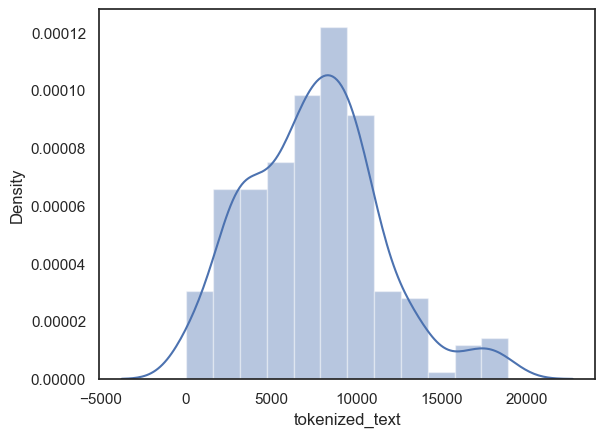

In [71]:
sns.distplot(train_df['tokenized_text'].apply(lambda x: len(x.split())))

In [72]:
len(token_ids[0])

4809

## Lemmatize sentiment

In [73]:
# pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [74]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,159
Litigious,749
Negative,2345
Positive,356
Strong_Modal,15
Uncertainty,252


## Tfidf 

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    vectorizer = TfidfVectorizer(analyzer='word', vocabulary=sentiment_words)
    tfidf = vectorizer.fit_transform(docs)
    features = vectorizer.get_feature_names()
    
    return tfidf.toarray()

### Text dataframe

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you have defined your lemma_sentiments and lemma_docs_org

# Function to calculate TF-IDF using TfidfVectorizer
def get_tfidf(words, documents):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    return tfidf_matrix

# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf_org = {
    sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)
    for sentiment in lemma_sentiments
}

# Printing the dimensions of the TF-IDF matrix for the 'Negative' sentiment
print(sentiment_tfidf_org['Negative'].shape)


(1178, 20773)


In [77]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.

"""

sentiment_tfidf_org = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf_org['Negative']))
print(len(sentiment_tfidf_org['Negative'][0]))
"""

"\n\nsentiment_tfidf_org = {\n        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)\n        for sentiment in lemma_sentiments}\n\nprint(len(sentiment_tfidf_org['Negative']))\nprint(len(sentiment_tfidf_org['Negative'][0]))\n"

In [78]:
text_df.shape

(1178, 19)

In [79]:
for sentiment in lemma_sentiments:
    text_df['tfidf_' + sentiment] = list(sentiment_tfidf_org[sentiment])
    
text_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,...,pos_words,neg_words,tokenized,token_ids,tfidf_Negative,tfidf_Uncertainty,tfidf_Constraining,tfidf_Positive,tfidf_Litigious,tfidf_Strong_Modal
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,...,[enhance],[misunderstanding],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(0, 5376)\t0.09053315787905611\n (0, 16262)...","(0, 5376)\t0.09053315787905611\n (0, 16262)...","(0, 5376)\t0.09053315787905611\n (0, 16262)...","(0, 5376)\t0.09053315787905611\n (0, 16262)...","(0, 5376)\t0.09053315787905611\n (0, 16262)...","(0, 5376)\t0.09053315787905611\n (0, 16262)..."
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,...,[],[],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(0, 18414)\t0.14445767541818053\n (0, 14459...","(0, 18414)\t0.14445767541818053\n (0, 14459...","(0, 18414)\t0.14445767541818053\n (0, 14459...","(0, 18414)\t0.14445767541818053\n (0, 14459...","(0, 18414)\t0.14445767541818053\n (0, 14459...","(0, 18414)\t0.14445767541818053\n (0, 14459..."
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,...,[],[],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 15, 11, 12, 13, 14, 15, 16,...","(0, 18414)\t0.1493688936424006\n (0, 14459)...","(0, 18414)\t0.1493688936424006\n (0, 14459)...","(0, 18414)\t0.1493688936424006\n (0, 14459)...","(0, 18414)\t0.1493688936424006\n (0, 14459)...","(0, 18414)\t0.1493688936424006\n (0, 14459)...","(0, 18414)\t0.1493688936424006\n (0, 14459)..."
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,...,[],[],"[in, take, discount, action, board, approve, r...","[51, 26, 52, 18, 53, 54, 55, 56, 53, 57, 58, 6...","(0, 5109)\t0.1644283732142964\n (0, 2419)\t...","(0, 5109)\t0.1644283732142964\n (0, 2419)\t...","(0, 5109)\t0.1644283732142964\n (0, 2419)\t...","(0, 5109)\t0.1644283732142964\n (0, 2419)\t...","(0, 5109)\t0.1644283732142964\n (0, 2419)\t...","(0, 5109)\t0.1644283732142964\n (0, 2419)\t..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,...,[],[],"[in, take, discount, rate, action, board, appr...","[51, 26, 52, 24, 18, 53, 54, 55, 56, 53, 57, 6...","(0, 5109)\t0.21021793139459033\n (0, 2419)\...","(0, 5109)\t0.21021793139459033\n (0, 2419)\...","(0, 5109)\t0.21021793139459033\n (0, 2419)\...","(0, 5109)\t0.21021793139459033\n (0, 2419)\...","(0, 5109)\t0.21021793139459033\n (0, 2419)\...","(0, 5109)\t0.21021793139459033\n (0, 2419)\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,testimony,2022-01-11,Nomination hearing,Jerome Powell,654,NaN,None,2022-01-26,0,0.00,...,"[opportunity, progress, enjoying, attractive, ...","[crisis, unemployment, imbalances, threatened,...","[chairman, brown, rank, member, toomey, member...","[1, 16736, 11592, 348, 20790, 348, 9, 9003, 14...","(0, 8365)\t0.11654743424813152\n (0, 4330)\...","(0, 8365)\t0.11654743424813152\n (0, 4330)\...","(0, 8365)\t0.11654743424813152\n (0, 4330)\...","(0, 8365)\t0.11654743424813152\n (0, 4330)\...","(0, 8365)\t0.11654743424813152\n (0, 4330)\...","(0, 8365)\t0.11654743424813152\n (0, 4330)\..."
1174,testimony,2022-03-02,Semiannual Monetary Policy Report to the Congress,Jerome Powell,801,NaN,None,2022-03-16,1,0.25,...,"[achieving, stability, progress, gains, improv...","[slowing, declined, sharply, slowdown, unemplo...","[at, federal, reserve, strongly, commit, achie...","[384, 6, 15, 794, 1206, 693, 32, 33, 389, 1702...","(0, 13519)\t0.12037446842462075\n (0, 12758...","(0, 13519)\t0.12037446842462075\n (0, 12758...","(0, 13519)\t0.12037446842462075\n (0, 12758...","(0, 13519)\t0.12037446842462075\n (0, 12758...","(0, 13519)\t0.12037446842462075\n (0, 12758...","(0, 13519)\t0.12037446842462075\n (0,

### Train dataframe

In [80]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs)
        for sentiment in lemma_sentiments}

#print(len(sentiment_tfidf['Negative']))
#print(len(sentiment_tfidf['Negative'][0]))

for sentiment in lemma_sentiments:
    train_df['tfidf_' + sentiment] = list(sentiment_tfidf[sentiment])
    
train_df

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/2509363975.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tfidf_' + sentiment] = list(sentiment_tfidf[sentiment])
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/2509363975.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tfidf_' + sentiment] = list(sentiment_tfidf[sentiment])
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/2509363975.py:10: SettingWithCopyWarning: 
A value is trying

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,...,tone,tokenized,token_ids,tokenized_text,tfidf_Negative,tfidf_Uncertainty,tfidf_Constraining,tfidf_Positive,tfidf_Litigious,tfidf_Strong_Modal
date,,,,,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.042880,54.2,257.5,2.015140,0.000000,-0.015006,14.901418,0.030023,...,-0.160909,"[the, secretary, report, advice, election, res...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13,...",the secretary report advice election reserve b...,"(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300..."
1993-05-18,0,0,0.166979,53.5,125.5,3.092456,0.066667,0.003106,13.455236,0.088803,...,-0.178945,"[at, start, meet, subcommittee, establish, rev...","[95, 485, 33, 348, 270, 334, 154, 357, 1127, 1...",at start meet subcommittee establish review po...,"(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)..."
1993-07-07,0,0,0.166979,51.2,228.0,4.263357,0.000000,0.053298,13.446869,-0.036990,...,-0.276393,"[the, committee, turn, discussion, economic, o...","[1, 13, 364, 365, 366, 367, 372, 274, 154, 373...",the committee turn discussion economic outlook...,"(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)..."
1993-08-17,0,0,0.582113,49.6,245.0,4.611673,0.066667,0.004418,11.927296,0.011994,...,-0.142653,"[the, committee, turn, discussion, economic, o...","[1, 13, 364, 365, 366, 367, 368, 369, 370, 371...",the committee turn discussion economic outlook...,"(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936..."
1993-09-21,0,0,0.582113,50.2,229.0,4.894733,0.100000,-0.004671,10.302509,-0.025253,...,-0.218009,"[secretary, note, advice, receive, election, w...","[2, 783, 4, 19, 5, 43, 44, 39, 1640, 10, 6, 7,...",secretary note advice receive election william...,"(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,1,1,0.801155,50.0,307.0,0.003324,0.033333,0.537643,-15.601750,0.205218,...,-0.885747,"[the, committee, seek, achieve, maximum, emplo...","[1, 13, 1086, 1027, 309, 394, 410, 166, 434, 9...",the committee seek achieve maximum employment ...,"(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981..."
2023-02-01,1,1,0.637398,49.0,264.5,-0.681562,0.000000,0.591459,-17.139080,0.039248,...,-0.259772,"[the, committee, seek, achieve, maximum, emplo...","[1, 13, 1086, 1027, 309, 394, 410, 166, 434, 9...",the committee seek achieve maximum employment ...,"(0, 10513)\t0.011867930162303605\n (0, 8332...","(0, 10513)\t0.011867930162303605\n (

In [81]:
train_df.shape

(271, 26)

## Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [82]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    #print(tfidf_matrix)
    return [cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0][0].tolist() for u, v in zip(tfidf_matrix, tfidf_matrix[1:])]

In [83]:
cosine_similarities = {
    sentiment_name: get_cosine_similarity(sentiment_values) 
    for sentiment_name, sentiment_values in sentiment_tfidf.items()}

print(len(cosine_similarities['Negative']))

270


In [84]:
for sentiment in lemma_sentiments:
    # Add 0 to the first element as there is no comparison available to a previous value
    cosine_similarities[sentiment].insert(0, 0)
    train_df['cos_sim_' + sentiment] = cosine_similarities[sentiment]
    
train_df

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/921564139.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cos_sim_' + sentiment] = cosine_similarities[sentiment]
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/921564139.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cos_sim_' + sentiment] = cosine_similarities[sentiment]
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/921564139.py:4: SettingWithCopyWarning: 
A value is trying to be

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,...,tfidf_Constraining,tfidf_Positive,tfidf_Litigious,tfidf_Strong_Modal,cos_sim_Negative,cos_sim_Uncertainty,cos_sim_Constraining,cos_sim_Positive,cos_sim_Litigious,cos_sim_Strong_Modal
date,,,,,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.042880,54.2,257.5,2.015140,0.000000,-0.015006,14.901418,0.030023,...,"(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1993-05-18,0,0,0.166979,53.5,125.5,3.092456,0.066667,0.003106,13.455236,0.088803,...,"(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)...",0.734915,0.734915,0.734915,0.734915,0.734915,0.734915
1993-07-07,0,0,0.166979,51.2,228.0,4.263357,0.000000,0.053298,13.446869,-0.036990,...,"(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)...",0.810295,0.810295,0.810295,0.810295,0.810295,0.810295
1993-08-17,0,0,0.582113,49.6,245.0,4.611673,0.066667,0.004418,11.927296,0.011994,...,"(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936...",0.807803,0.807803,0.807803,0.807803,0.807803,0.807803
1993-09-21,0,0,0.582113,50.2,229.0,4.894733,0.100000,-0.004671,10.302509,-0.025253,...,"(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)...",0.801490,0.801490,0.801490,0.801490,0.801490,0.801490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,1,1,0.801155,50.0,307.0,0.003324,0.033333,0.537643,-15.601750,0.205218,...,"(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981...",0.916457,0.916457,0.916457,0.916457,0.916457,0.916457
2023-02-01,1,1,0.637398,49.0,264.5,-0.681562,0.000000,0.591459,-17.139080,0.039248,...,"(0, 10513)\t0.011867930162303605\n (0, 8332...","(0, 10513)\t0.011867930162303605\n (0, 8332...","(0, 10513)\t0.011867930162303605\n (0, 8332...","(0, 10513)\t0.011867930162303605\n (0, 8332...",0.918275,0.918275,0.918275,0.918275,0.918275,0.918275
2023-03-22,1,1,0.637398,47.4,360.0,0.156065,0.000000,0.359631,-19.636462,-0.224769,...,"(0, 2617)\t0.010378394422672018\n (0, 3352)...","(0, 2617)\t0.010378394422672018\n (0, 3352)...","(0, 2617)\t0.010378394422672018\n (0, 3352)...","(0, 2617)\t0.010378394422672018\n (0, 3352)...",0.928814,0.928814,0.928814,0.928814,0.928814,0.928814


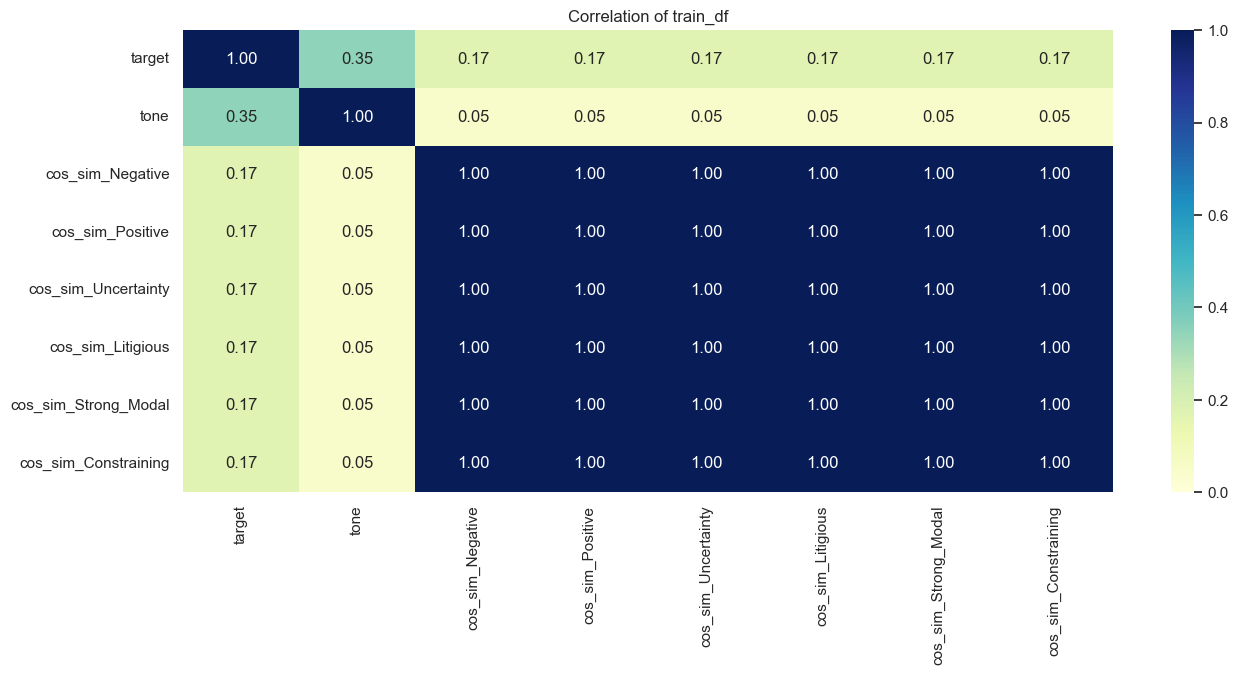

In [85]:
# Show corelations to target
fig, ax = plt.subplots(figsize=(15,6))
corr_columns = ['target', 'tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious', 'cos_sim_Strong_Modal', 'cos_sim_Constraining']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax, vmin=0, vmax=1)
ax.set_title("Correlation of train_df")
plt.show()

### Convert target class for classification

In [86]:
def convert_class(x):
    if x == 1:
        return 2
    elif x == 0:
        return 1
    elif x == -1:
        return 0

In [87]:
train_df['target'] = train_df['target'].map(convert_class)

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/2717173552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['target'] = train_df['target'].map(convert_class)


In [88]:
train_df['prev_decision'] = train_df['prev_decision'].map(convert_class)

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/3120950916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['prev_decision'] = train_df['prev_decision'].map(convert_class)


# Modeling and Training
## Common Functions

In [89]:
# Use Stratified KFold Cross Validation
# Training data is not so many, keep n_split <= 5
kfold = StratifiedKFold(n_splits=3)
kfold

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [90]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt



def plot_confusion_matrix_disp(estimator, X, y, display_labels, cmap, ax, normalize=None):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=cmap, ax=ax)

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))

        # ... (rest of the code)

        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)

        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)

        plot_confusion_matrix_disp(best_estimator, X_train, Y_train, display_labels=class_names,
                                  cmap=plt.cm.Blues, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)

        plot_confusion_matrix_disp(best_estimator, X_train, Y_train, display_labels=class_names,
                                  cmap=plt.cm.Blues, ax=ax2, normalize='all')
        ax2.set_title("Train Data: Normalized")
        ax2.grid(False)

        plot_confusion_matrix_disp(best_estimator, X_test, Y_test, display_labels=class_names,
                                  cmap=plt.cm.Blues, ax=ax3)
        ax3.set_title("Test Data: Actual Count")
        ax3.grid(False)

        plot_confusion_matrix_disp(best_estimator, X_test, Y_test, display_labels=class_names,
                                  cmap=plt.cm.Blues, ax=ax4, normalize='all')
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)

        plt.tight_layout(pad=3.0)
        plt.show()

    return model



## A. Cosin Similarity
### Train and Test Data

In [92]:
train_df.columns

Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'statement',
       'minutes', 'presconf_script', 'speech', 'testimony', 'text', 'tone',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Uncertainty', 'tfidf_Constraining', 'tfidf_Positive',
       'tfidf_Litigious', 'tfidf_Strong_Modal', 'cos_sim_Negative',
       'cos_sim_Uncertainty', 'cos_sim_Constraining', 'cos_sim_Positive',
       'cos_sim_Litigious', 'cos_sim_Strong_Modal'],
      dtype='object')

In [93]:
# X and Y data used
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 
                                     'cos_sim_Litigious', 'cos_sim_Strong_Modal', 'cos_sim_Constraining']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

### Train

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[2023-07-31 20:25:43,032][INFO] ## Training - acc: 0.99074074, f1: 0.98799698
[2023-07-31 20:25:43,032][INFO] ## Training - acc: 0.99074074, f1: 0.98799698
[2023-07-31 20:25:43,035][INFO] ## Test - acc: 0.69090909, f1: 0.57246309
[2023-07-31 20:25:43,035][INFO] ## Test - acc: 0.69090909, f1: 0.57246309


Best Score:  0.6100190262706097
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 20}


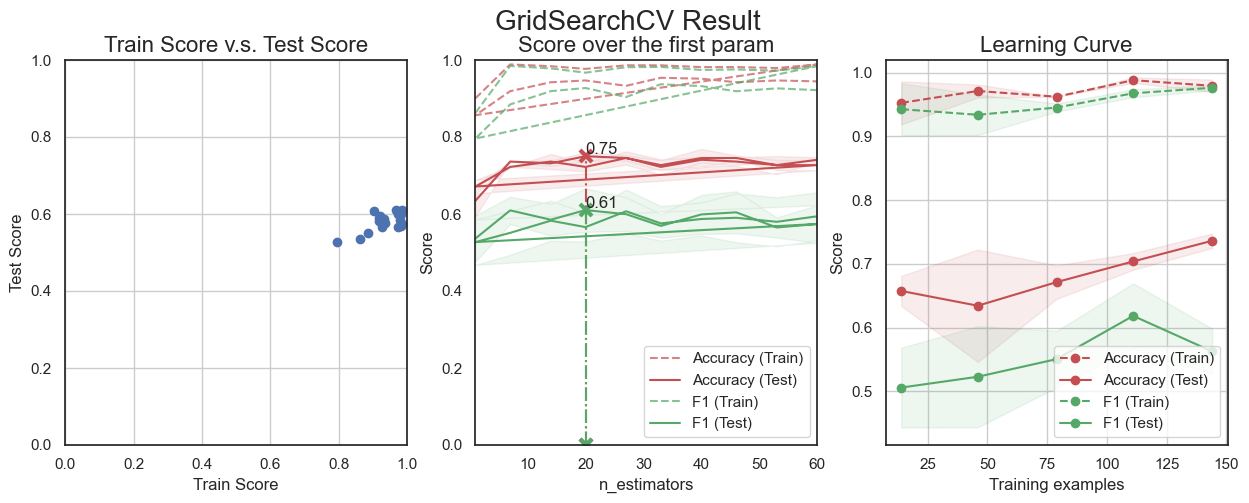

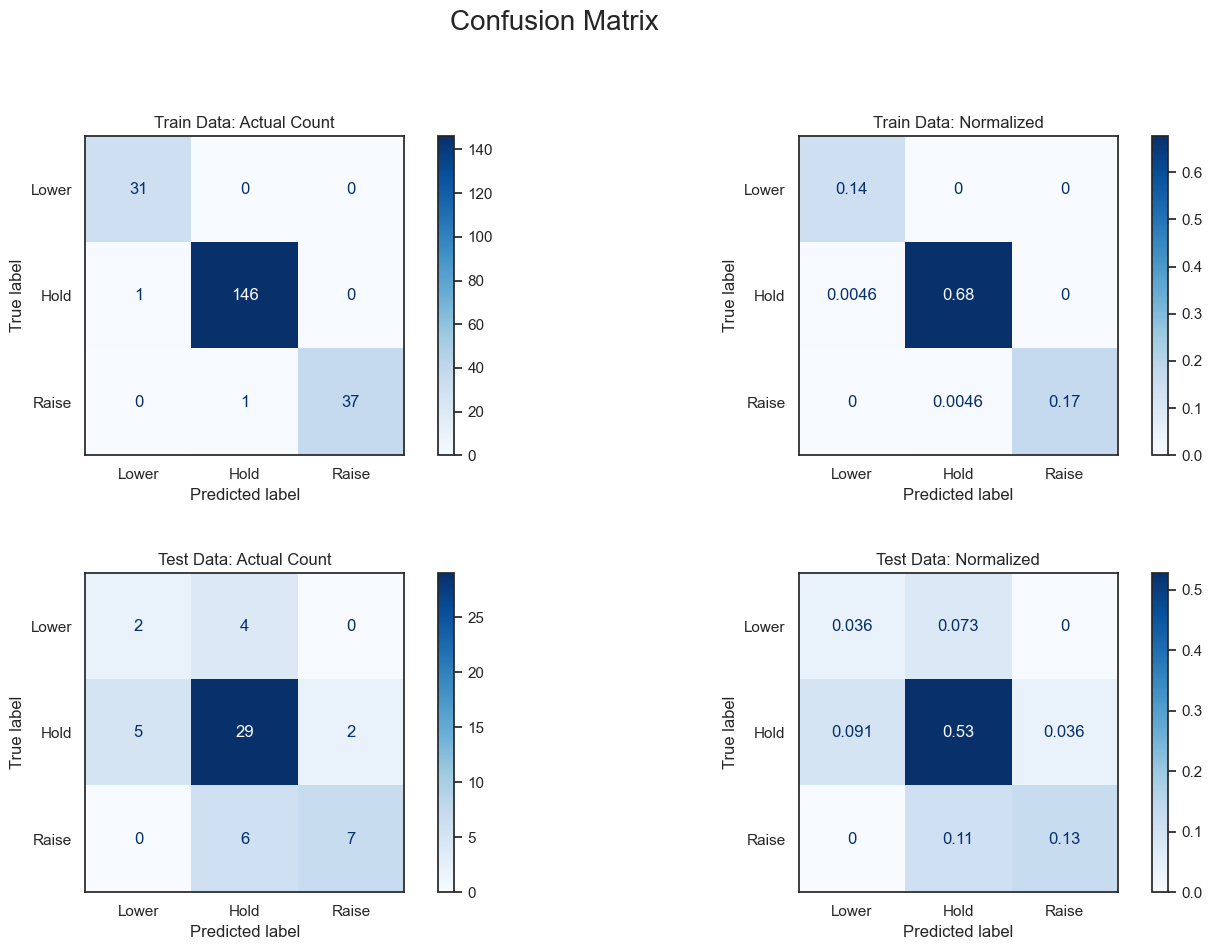

In [94]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [3, 10],
              'min_samples_leaf': [3],
              'max_features': [7],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

Text(0.5, 1.0, 'Feature importance')

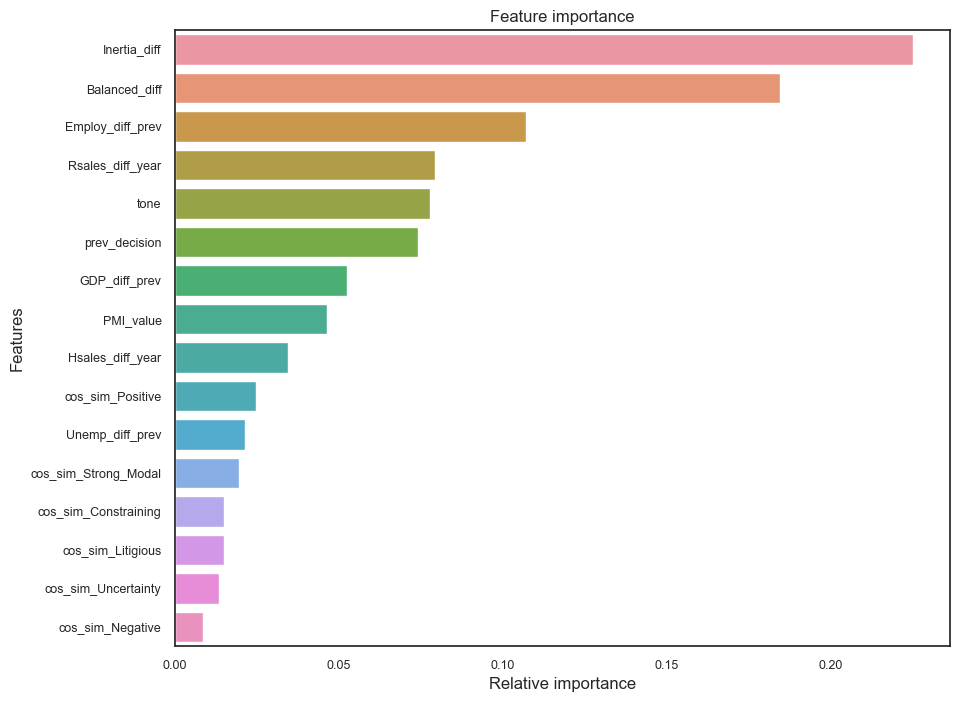

In [95]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")


## B. Tfidf
Use Tfidf instead of cosin similarity
### Train and Test Data

In [96]:
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,...,tfidf_Constraining,tfidf_Positive,tfidf_Litigious,tfidf_Strong_Modal,cos_sim_Negative,cos_sim_Uncertainty,cos_sim_Constraining,cos_sim_Positive,cos_sim_Litigious,cos_sim_Strong_Modal
date,,,,,,,,,,,,,,,,,,,,,
1993-02-18,1,1,1.042880,54.2,257.5,2.015140,0.000000,-0.015006,14.901418,0.030023,...,"(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300...","(0, 17084)\t0.006081481042316876\n (0, 1300...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1993-05-18,1,1,0.166979,53.5,125.5,3.092456,0.066667,0.003106,13.455236,0.088803,...,"(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)...","(0, 14086)\t0.010938539040142954\n (0, 164)...",0.734915,0.734915,0.734915,0.734915,0.734915,0.734915
1993-07-07,1,1,0.166979,51.2,228.0,4.263357,0.000000,0.053298,13.446869,-0.036990,...,"(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)...","(0, 17621)\t0.03208259293980267\n (0, 3557)...",0.810295,0.810295,0.810295,0.810295,0.810295,0.810295
1993-08-17,1,1,0.582113,49.6,245.0,4.611673,0.066667,0.004418,11.927296,0.011994,...,"(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936...","(0, 15132)\t0.010759162211295373\n (0, 3936...",0.807803,0.807803,0.807803,0.807803,0.807803,0.807803
1993-09-21,1,1,0.582113,50.2,229.0,4.894733,0.100000,-0.004671,10.302509,-0.025253,...,"(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)...","(0, 19223)\t0.02319083631306588\n (0, 8371)...",0.801490,0.801490,0.801490,0.801490,0.801490,0.801490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,2,2,0.801155,50.0,307.0,0.003324,0.033333,0.537643,-15.601750,0.205218,...,"(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981...","(0, 16183)\t0.010114800873105711\n (0, 1981...",0.916457,0.916457,0.916457,0.916457,0.916457,0.916457
2023-02-01,2,2,0.637398,49.0,264.5,-0.681562,0.000000,0.591459,-17.139080,0.039248,...,"(0, 10513)\t0.011867930162303605\n (0, 8332...","(0, 10513)\t0.011867930162303605\n (0, 8332...","(0, 10513)\t0.011867930162303605\n (0, 8332...","(0, 10513)\t0.011867930162303605\n (0, 8332...",0.918275,0.918275,0.918275,0.918275,0.918275,0.918275
2023-03-22,2,2,0.637398,47.4,360.0,0.156065,0.000000,0.359631,-19.636462,-0.224769,...,"(0, 2617)\t0.010378394422672018\n (0, 3352)...","(0, 2617)\t0.010378394422672018\n (0, 3352)...","(0, 2617)\t0.010378394422672018\n (0, 3352)...","(0, 2617)\t0.010378394422672018\n (0, 3352)...",0.928814,0.928814,0.928814,0.928814,0.928814,0.928814


In [97]:
vocabulary=sentiment_dict['Negative']+sentiment_dict['Positive']

In [98]:
# X and Y data used
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'tokenized_text']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

In [99]:
import scipy
def get_numeric_data(x):
    return [record[:-2].astype(float) for record in x]

def get_text_data(x):
    return [record[-1] for record in x]

from sklearn.preprocessing import FunctionTransformer
transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

clf = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word', vocabulary=vocabulary))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Score:  0.4320245797988597
Best Param:  {'clf__bootstrap': False, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 7, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 3, 'clf__n_estimators': 1}


[2023-07-31 20:25:54,528][INFO] ## Training - acc: 0.66666667, f1: 0.30513329
[2023-07-31 20:25:54,528][INFO] ## Training - acc: 0.66666667, f1: 0.30513329
[2023-07-31 20:25:54,531][INFO] ## Test - acc: 0.74545455, f1: 0.46329966
[2023-07-31 20:25:54,531][INFO] ## Test - acc: 0.74545455, f1: 0.46329966


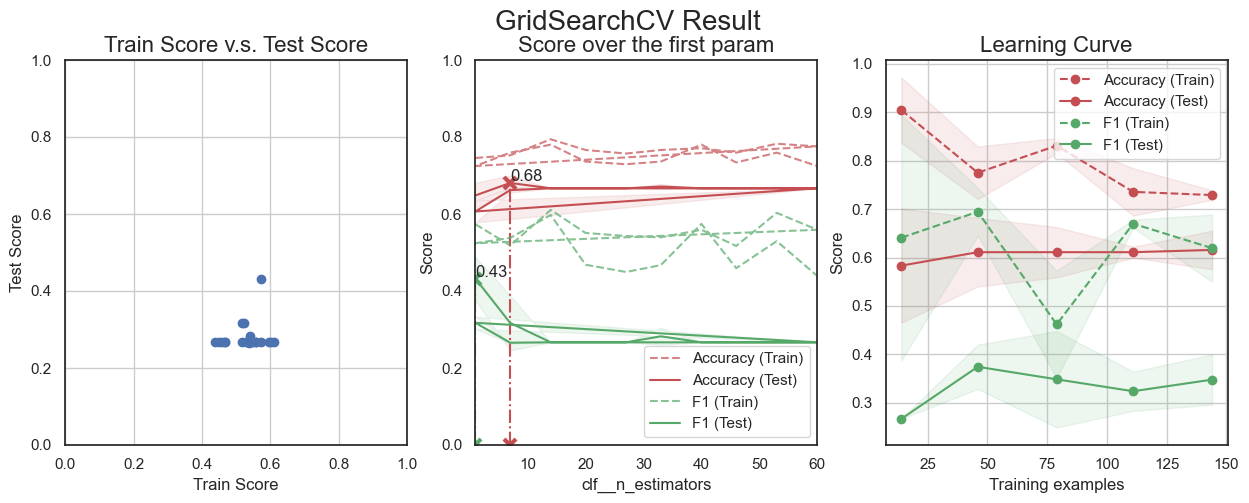

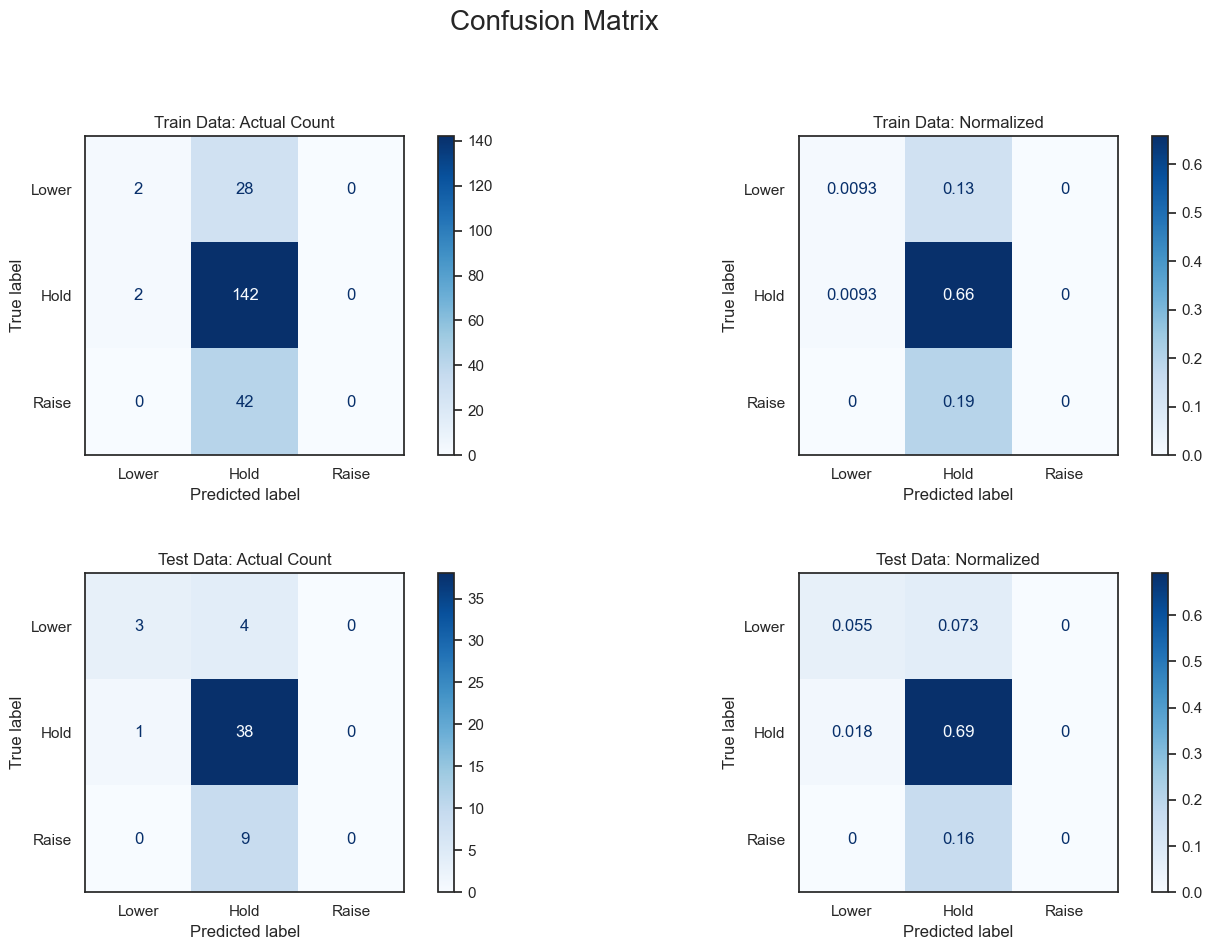

In [100]:
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word'))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

# Perform Grid Search
param_grid = {'clf__n_estimators': np.linspace(1, 60, 10, dtype=int),
              'clf__min_samples_split': [3, 10],
              'clf__min_samples_leaf': [3],
              'clf__max_features': [7],
              'clf__max_depth': [None],
              'clf__criterion': ['gini'],
              'clf__bootstrap': [False]}

rf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_



## C. LSTM (RNN)
Instead of Tfidf, use LSTM. Concatinate the lstm output and the meta data at the end and dense layer to fully connect them.

### Input Data

In [101]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'token_ids']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

X_train_meta = get_numeric_data(X_train)
X_train_text = get_text_data(X_train)
X_valid_meta = get_numeric_data(X_valid)
X_valid_text = get_text_data(X_valid)

print('Shape of train meta', len(X_train_meta))
print('Shape of train text', len(X_train_text))
print("Shape of valid meta ", len(X_valid_meta))
print("Shape of valid text ", len(X_valid_text))

meta_size = len(X_train_meta[0])
print("Meta data size: ", meta_size)

Shape of train meta 216
Shape of train text 216
Shape of valid meta  55
Shape of valid text  55
Meta data size:  9


### Model
#### Embed -> RNN -> Dense -> Softmax

In [102]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, meta_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, nn_input_meta, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(concat_layer)
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

can use keras functions but let's do it from scratch

In [103]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 100
# tokenizer_obj = Tokenizer()
# tokenizer_obj.fit_on_texts(balanced['texts'])
# sequences = tokenizer_obj.texts_to_sequences(balanced['texts'])

# text_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
# text_pad

In [104]:
def dataloader(messages, meta, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        meta = [meta[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # print(len(tokens))
            # print(len(tokens[0]))
            # print(token_tensor.shape)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            # print(token_tensor[:sequence_length].shape)
            # print(start_idx, batch_num)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        meta_tensor = torch.tensor(meta[ii: ii+len(batch_messages)])
        
        yield batch, meta_tensor, label_tensor

In [105]:
# Test
text_batch, meta_batch, labels = next(iter(dataloader(X_train_text, X_train_meta, y_train)))
model = TextClassifier(len(vocab), 512, 128, 8, meta_size, 3)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, meta_batch, hidden)
print(logps)

tensor([[-1.0563e+02, -3.0543e+01,  0.0000e+00],
        [-1.7542e+02, -6.1339e+01,  0.0000e+00],
        [ 0.0000e+00, -2.2164e+03, -3.2211e+03],
        [-9.7476e+01, -2.9232e+01,  0.0000e+00],
        [-1.1875e+02, -3.2800e+01,  0.0000e+00],
        [-1.8513e+01, -1.4415e+01, -5.9605e-07],
        [-8.3340e+00, -1.1468e-01, -2.2246e+00],
        [-6.9618e+01, -2.8703e+01,  0.0000e+00],
        [-5.0626e+00, -3.7011e-02, -3.5064e+00],
        [-5.7328e+01, -1.8020e+01,  0.0000e+00],
        [-1.8499e+02, -4.8805e+01,  0.0000e+00],
        [-9.4839e+01, -2.6782e+01,  0.0000e+00],
        [-4.1662e+00, -9.9127e-02, -2.5401e+00],
        [-4.3942e+01, -1.0600e+01, -2.4914e-05],
        [-5.4618e+00, -2.9572e-01, -1.3793e+00],
        [-5.4709e+01, -1.4753e+01, -3.5763e-07]],
       grad_fn=<LogSoftmaxBackward0>)


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/3397014565.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  meta_tensor = torch.tensor(meta[ii: ii+len(batch_messages)])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### Configure the model and train!

In [106]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(len(vocab)+1, 512, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(20794, 512)
  (lstm): LSTM(512, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [107]:
def train_model(model, epochs=3, batch_size=8, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        print('Starting epoch {}'.format(epoch + 1))
        hidden = model.init_hidden(batch_size)
        steps = 0
        y_valid_epoch = []
        predicted_valid_epoch = []

        for text_batch, meta_batch, labels in dataloader(
                X_train_text, X_train_meta, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, meta_batch, labels = text_batch.to(device), meta_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = model(text_batch, meta_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                model.eval()

                valid_losses = []
                accuracy = []
                predicted_valid = []
                y_valid_batch = []
                valid_hidden = model.init_hidden(batch_size)

                for text_batch, meta_batch, labels in dataloader(
                        X_valid_text, X_valid_meta, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

                    # Skip the last batch of which size is not equal to batch_size
                    if text_batch.size(1) != batch_size:
                        break

                    # Initialize within the loop to use label shape because batch_size did not work
                    # valid_hidden = model.init_hidden(labels.shape[0])

                    # Creating new variables for the hidden state
                    valid_hidden = tuple([each.data for each in valid_hidden])

                    # Set Device
                    text_batch, meta_batch, labels = text_batch.to(device), meta_batch.to(device), labels.to(device)
                    for each in valid_hidden:
                        each.to(device)

                    # Get output and hidden state from the model
                    valid_output, valid_hidden = model(text_batch, meta_batch, valid_hidden)

                    # Calculate the loss     
                    valid_loss = criterion(valid_output.squeeze(), labels)
                    valid_losses.append(valid_loss.item())

                    # Accuracy
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                    predicted_valid.extend(top_class.squeeze().cpu().numpy())
                    y_valid_batch.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

                model.train()
                acc, f1 = metric(y_valid_batch, predicted_valid)
                predicted_valid_epoch.extend(predicted_valid)
                y_valid_epoch.extend(y_valid_batch)

                print("Epoch: {}/{}...".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))
        print("{} steps in epoch {}".format(steps, epoch+1))
        class_names = ['Lower', 'Hold', 'Raise']
        y_valid_class = [class_names[int(idx)] for idx in y_valid_batch]
        predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
        titles_options = [("Confusion matrix, without normalization", None), ("Confusion matrix, with normalization", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
        acc, f1 = metric(y_valid_class, predicted_valid_class)
        print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
        plt.show()

Starting epoch 1
Epoch: 1/3... Step: 10... Loss: 62.195164... Val Loss: 50.895753 Accuracy: 0.312500 F1 Score: 0.283571
Epoch: 1/3... Step: 20... Loss: 54.909775... Val Loss: 50.567622 Accuracy: 0.291667 F1 Score: 0.257061
27 steps in epoch 1

Epoch: 1, Average Accuracy: 0.29166667, Average f1: 0.25706093



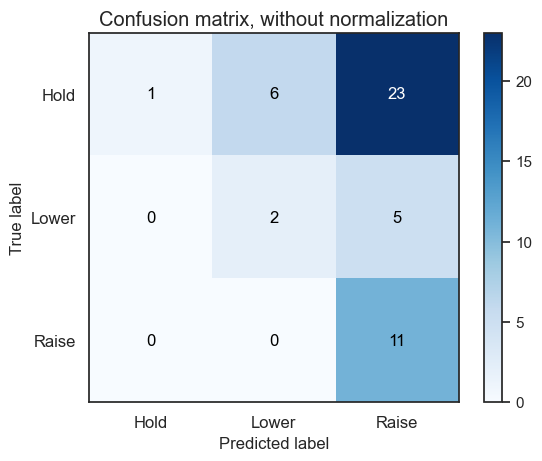

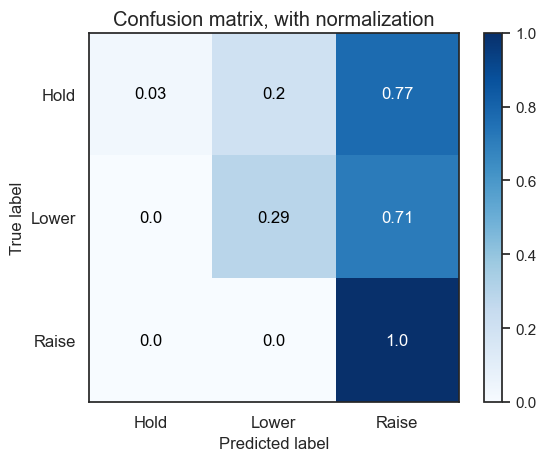

Starting epoch 2
Epoch: 2/3... Step: 10... Loss: 61.102772... Val Loss: 49.999830 Accuracy: 0.291667 F1 Score: 0.257061
Epoch: 2/3... Step: 20... Loss: 53.898060... Val Loss: 49.664946 Accuracy: 0.291667 F1 Score: 0.257061
27 steps in epoch 2

Epoch: 2, Average Accuracy: 0.29166667, Average f1: 0.25706093



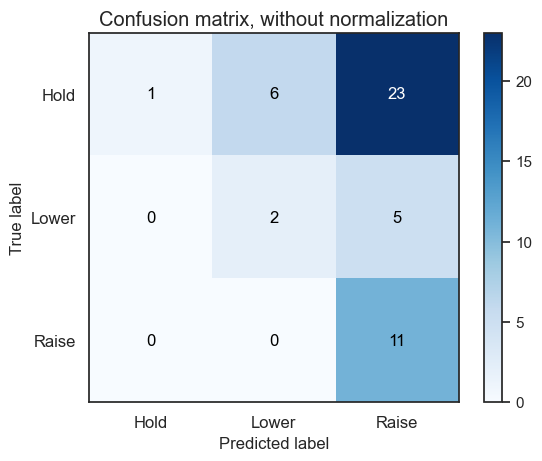

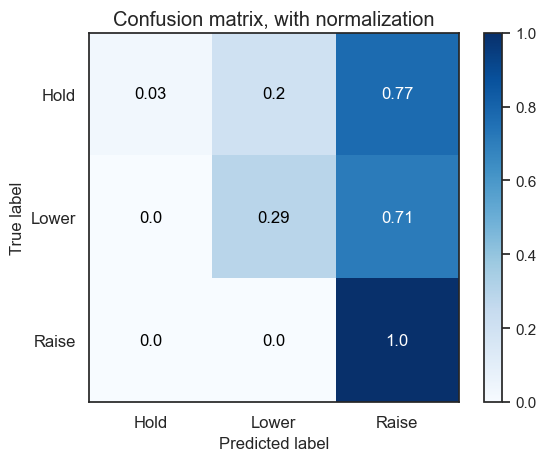

Starting epoch 3
Epoch: 3/3... Step: 10... Loss: 59.984161... Val Loss: 49.067921 Accuracy: 0.291667 F1 Score: 0.257061
Epoch: 3/3... Step: 20... Loss: 52.806866... Val Loss: 48.688529 Accuracy: 0.291667 F1 Score: 0.257061
27 steps in epoch 3

Epoch: 3, Average Accuracy: 0.29166667, Average f1: 0.25706093



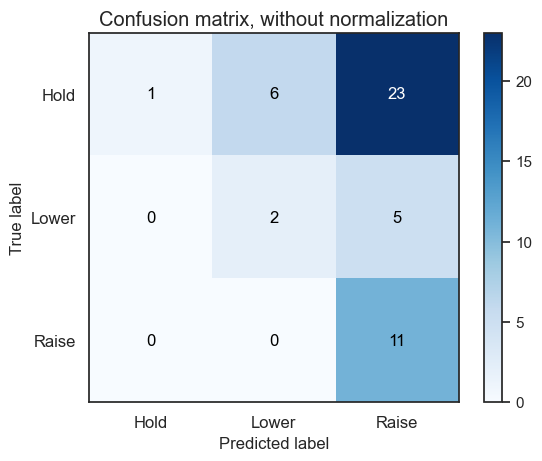

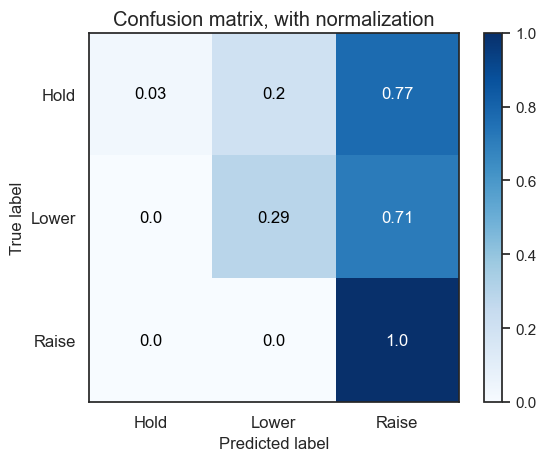

In [108]:
train_model(model)

## D. Glove Word Embedding + LSTM
Use GloVe word embedding instead of Tfidf

### Download GloVe files

In [109]:
# Use 6B 300d
glove_file = 'glove.6B.300d.pickle'
glove_path = glove_dir + glove_file
    
# Download Glove file if not exist

embedding_dict = {}

with open(glove_dir + "glove.6B.300d.txt", 'r',encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()

pickle.dump(embedding_dict, open(glove_path, 'wb'))

In [110]:
glove_dict = pickle.load(open(glove_path, 'rb'))
print(len(glove_dict))
glove_dict['the']

400000


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [111]:
weight_matrix = np.zeros((len(vocab), 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

11978 words found out of 20793 words in vocab.
(20793, 300)


In [112]:
type(weight_matrix)

numpy.ndarray

In [113]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, dense_size, meta_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, nn_input_meta, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(concat_layer)
        logps = self.softmax(out)

        return logps, hidden_state

### Configure the model and train!

In [114]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(20793, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Starting epoch 1
Epoch: 1/3... Step: 10... Loss: 25.305683... Val Loss: 31.082072 Accuracy: 0.500000 F1 Score: 0.270330
Epoch: 1/3... Step: 20... Loss: 1.603571... Val Loss: 30.891943 Accuracy: 0.500000 F1 Score: 0.270330
27 steps in epoch 1

Epoch: 1, Average Accuracy: 0.50000000, Average f1: 0.27032967



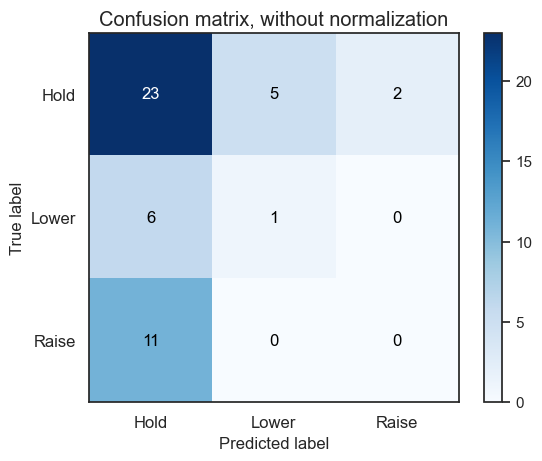

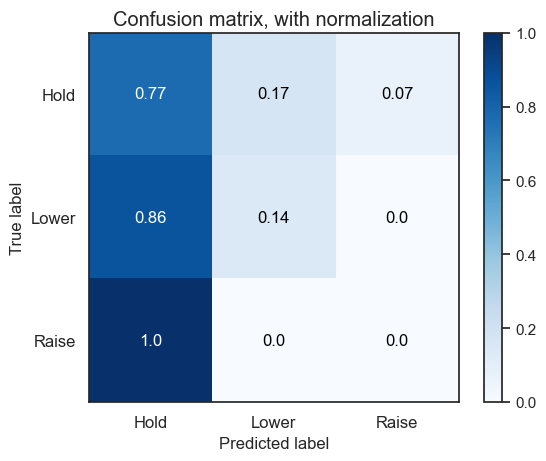

Starting epoch 2
Epoch: 2/3... Step: 10... Loss: 24.895494... Val Loss: 30.611458 Accuracy: 0.500000 F1 Score: 0.270330
Epoch: 2/3... Step: 20... Loss: 1.585563... Val Loss: 30.428464 Accuracy: 0.500000 F1 Score: 0.270330
27 steps in epoch 2

Epoch: 2, Average Accuracy: 0.50000000, Average f1: 0.27032967



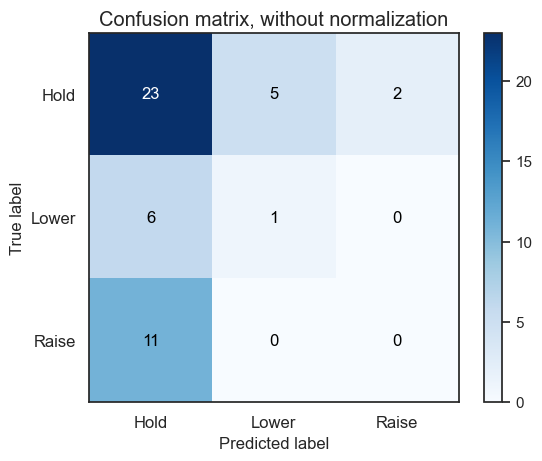

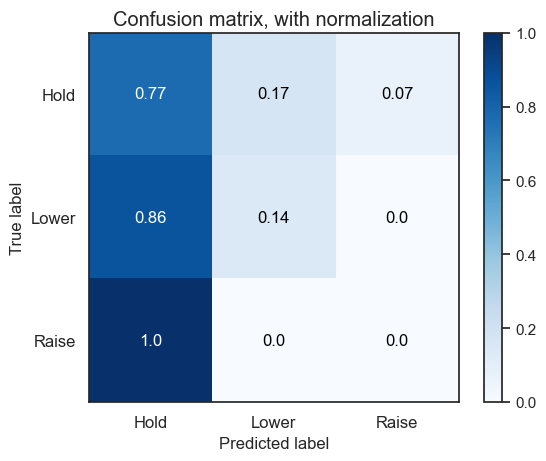

Starting epoch 3
Epoch: 3/3... Step: 10... Loss: 24.486490... Val Loss: 30.147093 Accuracy: 0.500000 F1 Score: 0.270330
Epoch: 3/3... Step: 20... Loss: 1.570359... Val Loss: 29.963562 Accuracy: 0.500000 F1 Score: 0.270330
27 steps in epoch 3

Epoch: 3, Average Accuracy: 0.50000000, Average f1: 0.27032967



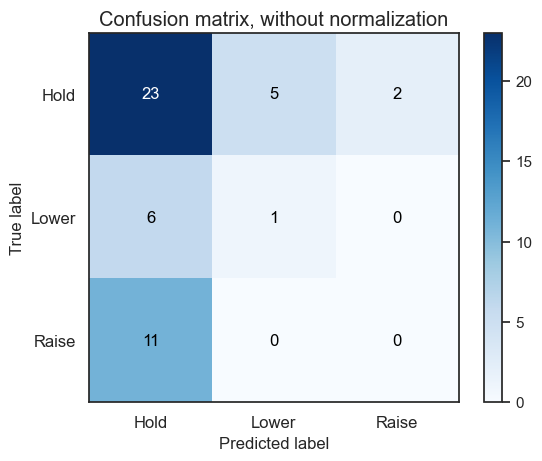

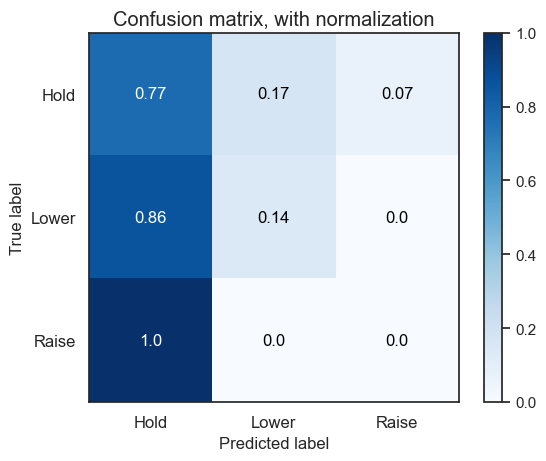

In [115]:
train_model(model)

The result does not look good. In fact, only the first hunderds of text can be used. Now, consider to split the text to the length of 200 with overlapping 50 words again.

In [116]:
train_df.columns

Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'statement',
       'minutes', 'presconf_script', 'speech', 'testimony', 'text', 'tone',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Uncertainty', 'tfidf_Constraining', 'tfidf_Positive',
       'tfidf_Litigious', 'tfidf_Strong_Modal', 'cos_sim_Negative',
       'cos_sim_Uncertainty', 'cos_sim_Constraining', 'cos_sim_Positive',
       'cos_sim_Litigious', 'cos_sim_Strong_Modal'],
      dtype='object')

In [117]:
split_train_df = train_df.drop(columns=['statement',
       'minutes', 'presconf_script', 'speech', 'testimony',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_Strong_Modal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_Strong_Modal', 'cos_sim_Constraining'])

In [118]:
split_train_df.shape

(271, 12)

In [119]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            #row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)

    return split_df

In [120]:
split_train_df = get_split_df(split_train_df)
split_train_df.shape

  0%|          | 0/271 [00:00<?, ?it/s]

(23454, 12)

In [121]:
tokenized = tokenize_df(split_train_df)
lemma_docs = [" ".join(words) for words in tokenized]
all_words = [word for text in tokenized for word in text]
counts = Counter(all_words)
bow = sorted(counts, key=counts.get, reverse=True)
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

# Add to the dataframe
split_train_df['token_ids'] = token_ids


  0%|          | 0/23454 [00:00<?, ?it/s]

In [122]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))
        

In [123]:
split_train_df.head()

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,text,tone,token_ids
0,1,1,1.04288,54.2,257.5,2.01514,0.0,-0.015006,14.901418,0.030023,The Secretary reported that advices of the ele...,-0.160909,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13,..."
1,1,1,1.04288,54.2,257.5,2.01514,0.0,-0.015006,14.901418,0.030023,Manager of the System Open Market Account Depu...,-0.160909,"[55, 56, 11, 12, 57, 58, 55, 59, 60, 56, 11, 1..."
2,1,1,1.04288,54.2,257.5,2.01514,0.0,-0.015006,14.901418,0.030023,the System Open Market Account that were conta...,-0.160909,"[56, 11, 12, 57, 103, 25, 77, 104, 105, 56, 11..."
3,1,1,1.04288,54.2,257.5,2.01514,0.0,-0.015006,14.901418,0.030023,allow them to mature without replacement provi...,-0.160909,"[144, 142, 145, 146, 147, 148, 149, 118, 119, ..."
4,1,1,1.04288,54.2,257.5,2.01514,0.0,-0.015006,14.901418,0.030023,to nine months at the time of acceptance that ...,-0.160909,"[175, 176, 177, 169, 178, 179, 180, 181, 182, ..."


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_4848/3491047501.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(split_train_df['text'].apply(lambda x: len(x.split())))


<Axes: xlabel='text', ylabel='Density'>

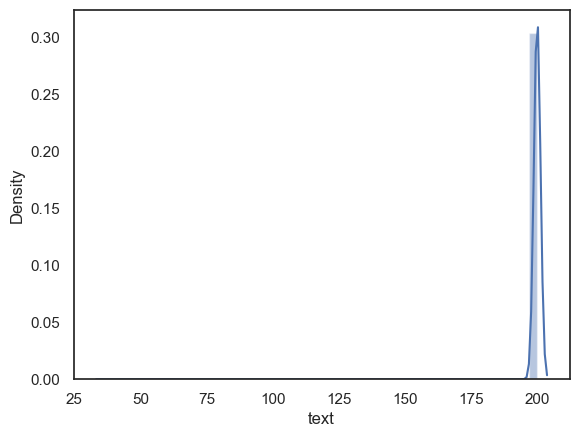

In [124]:
sns.distplot(split_train_df['text'].apply(lambda x: len(x.split())))

In [125]:
# X and Y data used
y_data = split_train_df['target']
X_data = split_train_df[nontext_columns + ['tone', 'token_ids']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

X_train_meta = get_numeric_data(X_train)
X_train_text = get_text_data(X_train)
X_valid_meta = get_numeric_data(X_valid)
X_valid_text = get_text_data(X_valid)

print('Shape of train meta', len(X_train_meta))
print('Shape of train text', len(X_train_text))
print("Shape of valid meta ", len(X_valid_meta))
print("Shape of valid text ", len(X_valid_text))

meta_size = len(X_train_meta[0])
print("Meta data size: ", meta_size)

Shape of train meta 18763
Shape of train text 18763
Shape of valid meta  4691
Shape of valid text  4691
Meta data size:  9


In [126]:
len(weight_matrix)

21274

In [127]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(21274, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [128]:
train_model(model, epochs=3, batch_size=16, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10)

Starting epoch 1


KeyboardInterrupt: 

## E. BERT Model

In [ ]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
#import torch

In [ ]:
class InputFeature(object):
    """ A single training/test data class """
    def __init__(self, id, input_ids, masks, segments, meta, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments,
            'meta': meta
        }
        self.label = label

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=200):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

In [ ]:
# Prepare training data
train_set = []
max_seq_length = 200
meta_size = 10

for index, row in tqdm(split_train_df.iterrows(), total=split_train_df.shape[0]):
    input_ids, masks, segments = bert_encoder(row['text'], max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, row[nontext_columns + ['tone']], int(row['target'])))    

train_labels = split_train_df['target'].astype(int).values

# numpy array to split train and valid within Fold later
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_meta =np.array([data.features['meta'] for data in train_set], dtype=np.float64)
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(split_train_df), 3), dtype=np.float32)

  0%|          | 0/23454 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(train_valid_meta[0])
print(train_valid_meta[1])

[ 1.00000000e+00  1.04287987e+00  5.42000000e+01  2.57500000e+02
  2.01514043e+00  0.00000000e+00 -1.50060758e-02  1.49014176e+01
  3.00234838e-02 -1.60908661e-01]
[ 1.00000000e+00  1.04287987e+00  5.42000000e+01  2.57500000e+02
  2.01514043e+00  0.00000000e+00 -1.50060758e-02  1.49014176e+01
  3.00234838e-02 -1.60908661e-01]


In [ ]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, meta_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, nn_input_meta):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        # print(len(dense_out[0]))
        # print(len(nn_input_meta[0]))
        # print(len(concat_layer[0]))
        # print("dense_out: \n", dense_out)
        # print("nn_input_meta: \n", nn_input_meta)
        # print("concat_layer: \n", concat_layer)
        out = self.fc2(concat_layer)
        #logps = self.softmax(out)

        return out

In [ ]:
# Check how BertTokenizer works
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

print(input_ids)
print(outputs) # The last hidden-state is the first element of the output tuple


tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]])
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.7003, -0.1815,  0.3297,  ..., -0.4838,  0.0680,  0.8901],
         [-1.0355, -0.2567, -0.0317,  ...,  0.3197,  0.3999,  0.1795],
         [ 0.6080,  0.2610, -0.3131,  ...,  0.0311, -0.6283, -0.1994]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-7.1946e-01, -2.1445e-01, -2.9576e-01,  3.6603e-01,  2.7968e-01,
          2.2183e-02,  5.7299e-01,  6.2331e-02,  5.9586e-02, -9.9965e-01,
          5.0146e-02,  4.4756e-01,  9.7612e-01,  3.3988e-02,  8.4495e-01,
         -3.6905e-01,  9.8649e-02, -3.7169e-01,  1.7371e-01,  1.1515e-01,
          4.4133e-01,  9.9525e-01,  3.7221e-01,  8.2881e-02,  2.1402e-01,


In [ ]:
# Test Tokenizer - Own Implementation
bert_model = BertTextClassifier(768, 128, meta_size, 3, dropout=0.1)

text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
print('text_ids: \n', text_ids)
print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
text_ids = torch.tensor(text_ids).unsqueeze(0)
print('text_ids (unsqueezed): \n', text_ids)
#print('pad_masks: ',pad_masks)
#print('segment_ids: ',segment_ids)
x_meta = torch.tensor([1,2,3,4,5,6,7,8,9,10]).unsqueeze(0)
outputs = bert_model(text_ids, x_meta)
print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs.detach())

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


text_ids: 
 [101, 7592, 1010, 2026, 3899, 2003, 10140, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text_ids (torch.tensor): 
 tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [ ]:
# Hyperparameters
learning_rate = 1e-5
num_epochs = 3
batch_size = 32
patience =2
file_name = 'model'
use_skf = True
bert_hidden_size = 768
bert_dense_size =128

In [ ]:
def train_bert(fold, train_indices, valid_indices):
    
    # Number of folds to iterrate
    # if fold == 3:
    #     break

    logger.info('================     fold {}        ==============='.format(fold))
    
    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    train_meta = torch.tensor(train_valid_meta[train_indices], dtype=torch.long)
    
    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)
    valid_meta = torch.tensor(train_valid_meta[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_meta, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_meta, valid_label)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
#     bert_model = BertForSequenceClassification.from_pretrained(
#         "bert-base-uncased",
#         num_labels = 3,
#         output_attentions = False,
#         output_hidden_states = False
#     )

    bert_model = BertTextClassifier(bert_hidden_size, bert_dense_size, meta_size, 3, dropout=0.1)
    
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    bert_model = bert_model.to(device)
    
    # Loss Function - use Cross Entropy as binary classification
    loss_fn = torch.nn.CrossEntropyLoss()

    # Optimizer - Adam with parameter groups
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)
    
    # Set Train Mode
    bert_model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}        ==============='.format(epoch+1))
        train_loss = 0.
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)
            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, x_meta, y_truth = batch
            
            # Feedforward prediction
            y_pred = bert_model(x_ids, x_meta)

            # Calculate Loss
            loss = loss_fn(y_pred, y_truth)
                        
            # Reset gradient
            optimizer.zero_grad()
            # Backward Propagation
            loss.backward()
            # Update Weights
            optimizer.step()
            # Training Loss
            train_loss += loss.item() / len(train_loader)
            
            logger.debug('train batch: %d, train_loss: %8f\n' % (i, train_loss))

        train_losses.append(train_loss)
        # Move to Evaluation Mode
        model.eval()
        
        # Initialize
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, x_meta, y_truth = batch
                y_pred = bert_model(x_ids, x_meta).detach()
                loss = loss_fn(y_pred, y_truth)
                val_loss += loss.item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()
                
                logger.debug('validation batch: {}, val_loss: {}, valid_preds_fold: {}'.format(i, val_loss, valid_preds_fold[i * batch_size:(i + 1) * batch_size]))
            valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(bert_model.state_dict(), output_dir + 'model_fold_{}.dict'.format(fold))
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.8f, f1: %.8f, best_f1: %.8f\n' %
            (epoch, train_loss, val_loss, acc, f1, best_f1))
        
        if device == 'cuda:0':
            torch.cuda.empty_cache()  

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break
            
        model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 3))
    
    # Draw training/validation losses
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (15,6)
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'b-o')

    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.show()

    # Load the best model
    bert_model.load_state_dict(torch.load(output_dir + 'model_fold_{}.dict'.format(fold)))
    # Set Evaluation Mode
    bert_model.eval()
    
    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, x_meta, y_truth = batch
            y_pred = bert_model(x_ids, x_meta).detach()
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()


    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    class_names = ['Lower', 'Hold', 'Raise']
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1), normalize=normalize, title=title)
    plt.show()

In [ ]:
if use_skf:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  
    for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
        train_bert(fold, train_indices, valid_indices)

else:
    train_ratio = 0.7
    train_indices = np.arange(0, int(len(train_valid_labels)*train_ratio))
    valid_indices = np.arange(int(len(train_valid_labels)*train_ratio), len(train_valid_labels))

    train_bert(0, train_indices, valid_indices)
    # print('train_indices', train_indices)
    # print('valid_indices', valid_indices)


[2023-07-27 16:35:29,338][INFO] ## ================     fold 0        ===============
[2023-07-27 16:35:29,338][INFO] ## ================     fold 0        ===============
[2023-07-27 16:35:30,908][INFO] ## ================     epoch 1        ===============
[2023-07-27 16:35:30,908][INFO] ## ================     epoch 1        ===============


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Validation:   0%|          | 0/147 [00:00<?, ?it/s]

[2023-07-27 21:46:19,193][INFO] ## epoch: 0, train loss: 30.00449356, valid loss: 29.14479529, acc: 0.19739928, f1: 0.14737929, best_f1: 0.14737929

[2023-07-27 21:46:19,193][INFO] ## epoch: 0, train loss: 30.00449356, valid loss: 29.14479529, acc: 0.19739928, f1: 0.14737929, best_f1: 0.14737929

[2023-07-27 21:46:19,226][INFO] ## ================     epoch 2        ===============
[2023-07-27 21:46:19,226][INFO] ## ================     epoch 2        ===============


Training:   0%|          | 0/587 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))
split_train_df['pred_target'] = np.argmax(oof_train, axis=1)
split_train_df['pred_target_lower'] = oof_train[:,0]
split_train_df['pred_target_hold'] = oof_train[:,1]
split_train_df['pred_target_raise'] = oof_train[:,2]
split_train_df.head()

[2023-07-27 23:49:17,571][INFO] ## 0.06419296420452356
[2023-07-27 23:49:17,571][INFO] ## 0.06419296420452356


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,text,tone,token_ids,pred_target,pred_target_lower,pred_target_hold,pred_target_raise
0,1,1,1.04288,54.2,257.5,2.01514,0.0,-0.015006,14.901418,0.030023,The Secretary reported that advices of the ele...,-0.160909,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13,...",0,0.0,0.0,0.0
1,1,1,1.04288,54.2,257.5,2.01514,0.0,-0.015006,14.901418,0.030023,Manager of the System Open Market Account Depu...,-0.160909,"[55, 56, 11, 12, 57, 58, 55, 59, 60, 56, 11, 1...",0,0.0,0.0,0.0
2,1,1,1.04288,54.2,257.5,2.01514,0.0,-0.015006,14.901418,0.030023,the System Open Market Account that were conta...,-0.160909,"[56, 11, 12, 57, 103, 25, 77, 104, 105, 56, 11...",0,0.0,0.0,0.0
3,1,1,1.04288,54.2,257.5,2.01514,0.0,-0.015006,14.901418,0.030023,allow them to mature without replacement provi...,-0.160909,"[144, 142, 145, 146, 147, 148, 149, 118, 119, ...",0,0.0,0.0,0.0
4,1,1,1.04288,54.2,257.5,2.01514,0.0,-0.015006,14.901418,0.030023,to nine months at the time of acceptance that ...,-0.160909,"[175, 176, 177, 169, 178, 179, 180, 181, 182, ...",0,0.0,0.0,0.0


# Save Data

In [ ]:
def save_data(df, file_name, dir_name=train_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save text data
save_data(train_df, 'train_df')
save_data(text_df, 'text_df')
save_data(train_df, 'split_train_df')